In [ ]:
import torch
import torchvision
import torchaudio

print(torch.__version__)
print(torchvision.__version__)
print(torchaudio.__version__)
print(torch.__version__)

: 

# GC

In [59]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

# train

## 

In [2]:
N_MFCC = 128
SIZE = 224

In [12]:
BATCH = 2
NUM_EPOCH = 50
LR = 0.00015

In [13]:
from tqdm import tqdm

In [14]:
import os
import json
import random
import torch
import numpy as np
import cv2
from torch.utils.data import Dataset
import torchaudio, torchvision
from torchaudio.compliance import kaldi
import imageio
import csv
from scipy.io import wavfile

class LRS3Dataset(Dataset):
    def __init__(self, root_dir, split="pretrain", transform=None, noise=False, snr=5, count=0):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.split = split 
        self.noise = noise
        self.snr = snr
        self.count = count
        # pretrain trainval test

        self.load_tsv_metadata(os.path.join(root_dir, f"{split}.tsv"))

        print(f"{split}::{len(self.data)}")

    def load_metadata(self, metadata_file):
        with open(metadata_file, 'r') as f:
            metadata = json.load(f)

        for item in metadata:
            video_path = os.path.join(self.root_dir, item['path']) 
            audio_path = video_path.replace(".mp4", ".wav")
            self.data.append((video_path, audio_path))
    
    def load_tsv_metadata(self, tsv_file_path):
        if 'train' in self.split:
            split = 'trainval'
        if 'test' in self.split:
            split = 'test'

        with open(tsv_file_path, 'r', encoding='utf-8') as f: 
            reader = csv.reader(f, delimiter='\t')
            next(reader)
            for row in reader:
                if not row:
                    continue
                video_path = row[1].replace('/video','')

                audio_path = row[2]

                video_path = video_path.replace('/home/youngchae/Desktop/datasets', "/media/ldh/f57e2fef-dda3-4234-9232-3e2867058140/datasets")


                noise = self.noise
                noise_type = "babble"
                snr = self.snr

                if not noise:
                    audio_path = audio_path.replace('/home/youngchae/Desktop/datasets', "/media/ldh/f57e2fef-dda3-4234-9232-3e2867058140/datasets") 


                else:
                    
                    audio_path = audio_path.replace('/home/youngchae/Desktop/datasets/lip_reading/lrs3/audio/', 
                                                    "/media/ldh/f57e2fef-dda3-4234-9232-3e2867058140/datasets/lip_reading/lrs3/noise_audio/").replace(
                                                        f'/{split}/',
                                                        f'/{noise_type}/{split}/snr_{snr}/') # noise
                    audio_path = audio_path.replace('/home/youngchae/Desktop/datasets', "/media/ldh/f57e2fef-dda3-4234-9232-3e2867058140/datasets") 

                self.data.append((video_path, audio_path))
        if self.count != 0:
            self.data = self.data[:self.count]

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        video_path, audio_path = self.data[idx]

        video, audio = self.load_video_and_audio(video_path)

        sample_rate, wav_data = wavfile.read(audio_path)
        data = torch.from_numpy(wav_data).float()
        audio_mel = self.mel_preprocessing_new(data.unsqueeze(0))
        return video, audio_mel


    def collate_fn(self, samples):
        min_frames = 16
        min_wav_length = min(sample[1].shape[0] for sample in samples)

        padded_frames = []
        padded_wavs = []

        for frames, wav in samples:
            if frames.shape[0] < min_frames:
                padding = min_frames - frames.shape[0]
                pad_frames = torch.zeros((padding, frames.shape[1], frames.shape[2], frames.shape[3]), dtype=frames.dtype)
                padded_frames.append(torch.cat((frames, pad_frames), dim=0))
            else:
                padded_frames.append(frames[:min_frames])
                
            padded_wavs.append(wav[:min_wav_length])

        return torch.stack(padded_frames), torch.stack(padded_wavs)
    
    def load_video_and_audio(self, video_path):
        reader = imageio.get_reader(video_path)
        frames = []
        W = SIZE
        H = SIZE

        for i, frame in enumerate(reader):
            if i % 5 == 0:  # 5fps로 조정
                frame = np.array(frame) 
                frame = cv2.resize(frame, (H, W))
                frames.append(frame)

        if len(frames) == 0:
            raise ValueError(f"No frames found in video: {video_path}")

        frames = np.array(frames).transpose((0, 3, 1, 2))  # (T, H, W, C) -> (T, C, H, W)
        frames = frames.astype(np.float32) / 255.0
        num_frames = frames.shape[0]
        self.target_frames = num_frames

        audio = self.load_audio_new(video_path)

        return torch.tensor(frames, dtype=torch.float32), audio
    
    def load_audio(self, video_path):
        audio_segment = AudioSegment.from_file(video_path)

        audio_array = np.array(audio_segment.get_array_of_samples(), dtype=np.float32)

        return audio_array
    
    def load_audio_new(self, video_path):
        waveform, sr = torchaudio.load(video_path)
        waveform = waveform - waveform.mean()
        return waveform

    def mel_preprocessing(self, audio_data, sr=16000, n_mels=128, n_fft=1024, hop_length=512):
        n_fft = int(sr * 0.032)  # 16ms
        hop_length = int(sr * 0.002)  # 4ms
        
        mel_spectrogram = librosa.feature.melspectrogram(
            y=audio_data, 
            sr=sr, 
            n_mels=n_mels, 
            n_fft=n_fft, 
            hop_length=hop_length
        )       
        # hopping window 16ms, every 4ms, 128 bins

        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        return torch.tensor(log_mel_spectrogram.T, dtype=torch.float32)
    
    def mel_preprocessing_new2(self, audio_data, sr=16000):
        # kaldi.fbank 설정 수정: frame_shift=10으로 변경
        fbank = torchaudio.compliance.kaldi.fbank(
            audio_data,
            htk_compat=True,
            sample_frequency=sr,
            use_energy=False,
            window_type='hanning',
            num_mel_bins=128,
            dither=0.0,
            frame_shift=10  # <-- _wav2fbank와 동일하게 수정
        )

        # 길이 조절 방식 수정: 선형 보간으로 변경
        TARGET_LEN = 768
        fbank = torch.nn.functional.interpolate(
            fbank.unsqueeze(0).transpose(1, 2),
            size=(TARGET_LEN,),
            mode='linear',
            align_corners=False
        ).transpose(1, 2).squeeze(0)

        return fbank
    def mel_preprocessing_new(self, audio_data, sr=16000):
        fbank = kaldi.fbank(audio_data, htk_compat=True, sample_frequency=sr, use_energy=False, 
        window_type='hanning', num_mel_bins=128, dither=0.0, frame_shift=4 ,frame_length= 16)
        n_frames = fbank.shape[0]
        TARGET_LEN = 768
        p = TARGET_LEN - n_frames
        # cut and pad
        if p > 0:
            m = torch.nn.ZeroPad2d((0, 0, 0, p))
            fbank = m(fbank)
        elif p < 0:
            fbank = fbank[0:TARGET_LEN, :]
        return fbank

    def _wav2fbank(self, filename):
        waveform, sr = torchaudio.load(filename)
        waveform = waveform - waveform.mean()

        try:
            fbank = torchaudio.compliance.kaldi.fbank(waveform, htk_compat=True, sample_frequency=sr, use_energy=False, window_type='hanning', num_mel_bins=self.melbins, dither=0.0, frame_shift=10)
        except:
            fbank = torch.zeros([512, 128]) + 0.01
            print('there is a loading error')

        target_length = self.target_length
        # n_frames = fbank.shape[0]

        # p = target_length - n_frames

        # # cut and pad
        # if p > 0:
        #     m = torch.nn.ZeroPad2d((0, 0, 0, p))
        #     fbank = m(fbank)
        # elif p < 0:
        #     fbank = fbank[0:target_length, :]

        fbank = torch.nn.functional.interpolate(fbank.unsqueeze(0).transpose(1,2), size=(target_length, ), mode='linear', align_corners=False).transpose(1,2).squeeze(0)

        return fbank

    def norm_fbank(self, fbank):
        norm_mean= -4.2677393
        norm_std= 4.5689974
        fbank = (fbank - norm_mean) / (norm_std * 2)
        return fbank


In [15]:
import torch
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# root_path = "/media/ldh/sda1/lrs3"
root_path = "/media/ldh/f57e2fef-dda3-4234-9232-3e2867058140/datasets/lip_reading/lrs3/30h_data"

train_dataset = LRS3Dataset(root_path, split="train")

num_workers = 20
train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=num_workers, collate_fn=train_dataset.collate_fn)

for video, audio in train_loader:
    print(f"Train Video shape: {video.shape}, {audio.shape}")
    
    break

train::30782
Train Video shape: torch.Size([2, 16, 3, 224, 224]), torch.Size([2, 768, 128])


In [16]:
import torchaudio
from torchaudio.compliance import kaldi

MELBINS=128
TARGET_LEN=1024

def wav2fbank(filename):

    waveform, sr = torchaudio.load(filename)
    waveform = waveform - waveform.mean()

    sr = 16000  # 샘플링 주파수
    audio_data = ...  # 오디오 데이터

    # 498 128
    fbank = kaldi.fbank(waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
                        window_type='hamming', num_mel_bins=MELBINS, dither=0.0, frame_shift=4)
    # AudioSet: 1024 (16K sr)
    n_frames = fbank.shape[0]
    p = TARGET_LEN - n_frames
    # cut and pad
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = m(fbank)
    elif p < 0:
        fbank = fbank[0:TARGET_LEN, :]
    return fbank
def norm_fbank(fbank):
    norm_mean= -4.2677393
    norm_std= 4.5689974
    fbank = (fbank - norm_mean) / (norm_std * 2)
    return fbank
def display_fbank(bank, minmin=None, maxmax=None):
    #print(bank.shape, bank.min(), bank.max())
    #plt.figure(figsize=(18, 6))
    plt.figure(figsize=(20, 4))
    plt.imshow(20*bank.T.detach().numpy(), origin='lower', interpolation='nearest', vmax=maxmax, vmin=minmin,  aspect='auto')
    #plt.colorbar()
    #S_db = librosa.amplitude_to_db(np.abs(bank.T.numpy()),ref=np.max)
    #S_db = bank.T.numpy()
    #plt.figure()
    #librosa.display.specshow(10*bank.T.numpy())
    #plt.colorbar()

In [17]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [18]:
import os
os.environ['TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD'] = '1'

In [19]:
import torch
from model.AVFF import AVFF

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AVFF()


/home/ldh/anaconda3/envs/avff/lib/python3.9/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/ldh/AVSR/av_hubert/avhubert/AVFF/model/AVFF.py:84: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  checkpoint = torch.load(audioMAE_path, map_location='cuda')


In [ ]:
## visualize
import torch
import matplotlib.pyplot as plt

def plot_test(video, audio, v_rec, a_rec):
    minmin=-10
    maxmax=10
    ##display_fbank(audio.squeeze(), minmin=minmin, maxmax=10)
    ##display_fbank(a_rec.squeeze(), minmin=-10, maxmax=10)

    mel_spectrogram = audio.squeeze().T.detach().numpy()
    #mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    maxmax = mel_spectrogram.max()
    minmin = mel_spectrogram.min()

    plt.figure(figsize=(10,4))
    plt.imshow(mel_spectrogram, interpolation='nearest', vmax=maxmax, vmin=minmin, aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.xlabel('Frames')
    plt.ylabel('Mel Bands')
    plt.show()

    #a_rec = torch.einsum('nchw->nhwc', a_rec).detach().cpu()

    image = a_rec.squeeze(0).T  # (1024, 128)

    # 텐서를 numpy 배열로 변환
    image = image.detach().numpy()
    #image = librosa.power_to_db(image, ref=np.max)

    maxmax = image.max()
    minmin = image.min()
    plt.figure(figsize=(10,4))
    plt.imshow(image, interpolation='nearest', vmax=maxmax, vmin=minmin, aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.xlabel('Frames')

    num_frames = video.size(2)  # 프레임 수
    frame_indices = range(num_frames)  # 프레임 인덱스 범위

    # 서브플롯 생성
    fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))

    for i, frame_index in enumerate(frame_indices):
        frame = video[0, :, frame_index, :, :] 
        frame = frame.permute(1, 2, 0).detach().numpy() 
        frame = frame[..., ::-1]
        frame = (frame - frame.min()) / (frame.max() - frame.min() + 1e-6)
        
        axes[i].imshow(frame)
        axes[i].axis('off')  
        axes[i].set_title(f'Frame {frame_index + 1}')  

    plt.tight_layout()  # 서브플롯 간격 조정
    plt.show()

    num_frames = v_rec.size(2)  # 프레임 수
    frame_indices = range(num_frames)  # 프레임 인덱스 범위

    # 서브플롯 생성
    fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))

    for i, frame_index in enumerate(frame_indices):
        frame = v_rec[0, :, frame_index, :, :]
        frame = frame.permute(1, 2, 0).detach().numpy()  
        frame = frame[..., ::-1]
        frame = (frame - frame.min()) / (frame.max() - frame.min() + 1e-6)
        
        axes[i].imshow(frame)
        axes[i].axis('off')  
        axes[i].set_title(f'Frame {frame_index + 1}')  

    plt.tight_layout()  # 서브플롯 간격 조정
    plt.show()


In [21]:
import torch

def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

trainable_params = count_trainable_params(model)
print(f'Trainable parameters: {trainable_params}')


Trainable parameters: 241890294


## EMA

In [25]:
import torch
import torch.distributed as dist


def zeropower_via_newtonschulz5(G, steps: int):
    """
    Newton-Schulz iteration to compute the zeroth power / orthogonalization of G. We opt to use a
    quintic iteration whose coefficients are selected to maximize the slope at zero. For the purpose
    of minimizing steps, it turns out to be empirically effective to keep increasing the slope at
    zero even beyond the point where the iteration no longer converges all the way to one everywhere
    on the interval. This iteration therefore does not produce UV^T but rather something like US'V^T
    where S' is diagonal with S_{ii}' ~ Uniform(0.5, 1.5), which turns out not to hurt model
    performance at all relative to UV^T, where USV^T = G is the SVD.
    """
    assert G.ndim >= 2 # batched Muon implementation by @scottjmaddox, and put into practice in the record by @YouJiacheng
    a, b, c = (3.4445, -4.7750,  2.0315)
    X = G.bfloat16()
    if G.size(-2) > G.size(-1):
        X = X.mT

    # Ensure spectral norm is at most 1
    X = X / (X.norm(dim=(-2, -1), keepdim=True) + 1e-7)
    # Perform the NS iterations
    for _ in range(steps):
        A = X @ X.mT
        B = b * A + c * A @ A # quintic computation strategy adapted from suggestion by @jxbz, @leloykun, and @YouJiacheng
        X = a * X + B @ X
    
    if G.size(-2) > G.size(-1):
        X = X.mT
    return X


def muon_update(grad, momentum, beta=0.95, ns_steps=5, nesterov=True):
    momentum.lerp_(grad, 1 - beta)
    update = grad.lerp_(momentum, beta) if nesterov else momentum
    if update.ndim == 4: # for the case of conv filters
        update = update.view(len(update), -1)
    update = zeropower_via_newtonschulz5(update, steps=ns_steps)
    update *= max(1, grad.size(-2) / grad.size(-1))**0.5
    return update


class Muon(torch.optim.Optimizer):
    """
    Muon - MomentUm Orthogonalized by Newton-schulz

    https://kellerjordan.github.io/posts/muon/

    Muon internally runs standard SGD-momentum, and then performs an orthogonalization post-
    processing step, in which each 2D parameter's update is replaced with the nearest orthogonal
    matrix. For efficient orthogonalization we use a Newton-Schulz iteration, which has the
    advantage that it can be stably run in bfloat16 on the GPU.

    Muon should only be used for hidden weight layers. The input embedding, final output layer,
    and any internal gains or biases should be optimized using a standard method such as AdamW.
    Hidden convolutional weights can be trained using Muon by viewing them as 2D and then
    collapsing their last 3 dimensions.

    Arguments:
        lr: The learning rate, in units of spectral norm per update.
        weight_decay: The AdamW-style weight decay.
        momentum: The momentum. A value of 0.95 here is usually fine.
    """
    def __init__(self, params, lr=0.02, weight_decay=0, momentum=0.95):
        defaults = dict(lr=lr, weight_decay=weight_decay, momentum=momentum)
        assert isinstance(params, list) and len(params) >= 1 and isinstance(params[0], torch.nn.Parameter)
        params = sorted(params, key=lambda x: x.size(), reverse=True)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):

        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params = group["params"]
            params_pad = params + [torch.empty_like(params[-1])] * (dist.get_world_size() - len(params) % dist.get_world_size())
            for base_i in range(len(params))[::dist.get_world_size()]:
                if base_i + dist.get_rank() < len(params):
                    p = params[base_i + dist.get_rank()]
                    if p.grad is None:
                        # continue
                        p.grad = torch.zeros_like(p)  # Force synchronization
                    state = self.state[p]
                    if len(state) == 0:
                        state["momentum_buffer"] = torch.zeros_like(p)
                    update = muon_update(p.grad, state["momentum_buffer"], beta=group["momentum"])
                    p.mul_(1 - group["lr"] * group["weight_decay"])
                    p.add_(update.reshape(p.shape), alpha=-group["lr"])
                dist.all_gather(params_pad[base_i:base_i + dist.get_world_size()], params_pad[base_i + dist.get_rank()])

        return loss


class SingleDeviceMuon(torch.optim.Optimizer):
    """
    Muon variant for usage in non-distributed settings.
    """
    def __init__(self, params, lr=0.02, weight_decay=0, momentum=0.95):
        defaults = dict(lr=lr, weight_decay=weight_decay, momentum=momentum)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):

        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    # continue
                    p.grad = torch.zeros_like(p)  # Force synchronization
                state = self.state[p]
                if len(state) == 0:
                    state["momentum_buffer"] = torch.zeros_like(p)
                update = muon_update(p.grad, state["momentum_buffer"], beta=group["momentum"])
                p.mul_(1 - group["lr"] * group["weight_decay"])
                p.add_(update.reshape(p.shape), alpha=-group["lr"])

        return loss


def adam_update(grad, buf1, buf2, step, betas, eps):
    buf1.lerp_(grad, 1 - betas[0])
    buf2.lerp_(grad.square(), 1 - betas[1])
    buf1c = buf1 / (1 - betas[0]**step)
    buf2c = buf2 / (1 - betas[1]**step)
    return buf1c / (buf2c.sqrt() + eps)


class MuonWithAuxAdam(torch.optim.Optimizer):
    """
    Distributed Muon variant that can be used for all parameters in the network, since it runs an
    internal AdamW for the parameters that are not compatible with Muon. The user must manually
    specify which parameters shall be optimized with Muon and which with Adam by passing in a
    list of param_groups with the `use_muon` flag set.

    The point of this class is to allow the user to have a single optimizer in their code, rather
    than having both a Muon and an Adam which each need to be stepped.

    You can see an example usage below:

    https://github.com/KellerJordan/modded-nanogpt/blob/master/records/052525_MuonWithAuxAdamExample/b01550f9-03d8-4a9c-86fe-4ab434f1c5e0.txt#L470
    ```
    hidden_matrix_params = [p for n, p in model.blocks.named_parameters() if p.ndim >= 2 and "embed" not in n]
    embed_params = [p for n, p in model.named_parameters() if "embed" in n]
    scalar_params = [p for p in model.parameters() if p.ndim < 2]
    head_params = [model.lm_head.weight]

    from muon import MuonWithAuxAdam
    adam_groups = [dict(params=head_params, lr=0.22), dict(params=embed_params, lr=0.6), dict(params=scalar_params, lr=0.04)]
    adam_groups = [dict(**g, betas=(0.8, 0.95), eps=1e-10, use_muon=False) for g in adam_groups]
    muon_group = dict(params=hidden_matrix_params, lr=0.05, momentum=0.95, use_muon=True)
    param_groups = [*adam_groups, muon_group]
    optimizer = MuonWithAuxAdam(param_groups)
    ```
    """
    def __init__(self, param_groups):
        for group in param_groups:
            assert "use_muon" in group
            if group["use_muon"]:
                group["params"] = sorted(group["params"], key=lambda x: x.size(), reverse=True)
                # defaults
                group["lr"] = group.get("lr", 0.02)
                group["momentum"] = group.get("momentum", 0.95)
                group["weight_decay"] = group.get("weight_decay", 0)
                assert set(group.keys()) == set(["params", "lr", "momentum", "weight_decay", "use_muon"])
            else:
                # defaults
                group["lr"] = group.get("lr", 3e-4)
                group["betas"] = group.get("betas", (0.9, 0.95))
                group["eps"] = group.get("eps", 1e-10)
                group["weight_decay"] = group.get("weight_decay", 0)
                assert set(group.keys()) == set(["params", "lr", "betas", "eps", "weight_decay", "use_muon"])
        super().__init__(param_groups, dict())

    @torch.no_grad()
    def step(self, closure=None):

        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            if group["use_muon"]:
                params = group["params"]
                params_pad = params + [torch.empty_like(params[-1])] * (dist.get_world_size() - len(params) % dist.get_world_size())
                for base_i in range(len(params))[::dist.get_world_size()]:
                    if base_i + dist.get_rank() < len(params):
                        p = params[base_i + dist.get_rank()]
                        if p.grad is None:
                            # continue
                            p.grad = torch.zeros_like(p)  # Force synchronization
                        state = self.state[p]
                        if len(state) == 0:
                            state["momentum_buffer"] = torch.zeros_like(p)
                        update = muon_update(p.grad, state["momentum_buffer"], beta=group["momentum"])
                        p.mul_(1 - group["lr"] * group["weight_decay"])
                        p.add_(update.reshape(p.shape), alpha=-group["lr"])
                    dist.all_gather(params_pad[base_i:base_i + dist.get_world_size()], params_pad[base_i + dist.get_rank()])
            else:
                for p in group["params"]:
                    if p.grad is None:
                        # continue
                        p.grad = torch.zeros_like(p)  # Force synchronization
                    state = self.state[p]
                    if len(state) == 0:
                        state["exp_avg"] = torch.zeros_like(p)
                        state["exp_avg_sq"] = torch.zeros_like(p)
                        state["step"] = 0
                    state["step"] += 1
                    update = adam_update(p.grad, state["exp_avg"], state["exp_avg_sq"],
                                         state["step"], group["betas"], group["eps"])
                    p.mul_(1 - group["lr"] * group["weight_decay"])
                    p.add_(update, alpha=-group["lr"])

        return loss


class SingleDeviceMuonWithAuxAdam(torch.optim.Optimizer):
    """
    Non-distributed variant of MuonWithAuxAdam.
    """
    def __init__(self, param_groups):
        for group in param_groups:
            assert "use_muon" in group
            if group["use_muon"]:
                # defaults
                group["lr"] = group.get("lr", 0.02)
                group["momentum"] = group.get("momentum", 0.95)
                group["weight_decay"] = group.get("weight_decay", 0)
                assert set(group.keys()) == set(["params", "lr", "momentum", "weight_decay", "use_muon"])
            else:
                # defaults
                group["lr"] = group.get("lr", 3e-4)
                group["betas"] = group.get("betas", (0.9, 0.95))
                group["eps"] = group.get("eps", 1e-10)
                group["weight_decay"] = group.get("weight_decay", 0)
                assert set(group.keys()) == set(["params", "lr", "betas", "eps", "weight_decay", "use_muon"])
        super().__init__(param_groups, dict())

    @torch.no_grad()
    def step(self, closure=None):

        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            if group["use_muon"]:
                for p in group["params"]:
                    if p.grad is None:
                        # continue
                        p.grad = torch.zeros_like(p)  # Force synchronization
                    state = self.state[p]
                    if len(state) == 0:
                        state["momentum_buffer"] = torch.zeros_like(p)
                    update = muon_update(p.grad, state["momentum_buffer"], beta=group["momentum"])
                    p.mul_(1 - group["lr"] * group["weight_decay"])
                    p.add_(update.reshape(p.shape), alpha=-group["lr"])
            else:
                for p in group["params"]:
                    if p.grad is None:
                        # continue
                        p.grad = torch.zeros_like(p)  # Force synchronization
                    state = self.state[p]
                    if len(state) == 0:
                        state["exp_avg"] = torch.zeros_like(p)
                        state["exp_avg_sq"] = torch.zeros_like(p)
                        state["step"] = 0
                    state["step"] += 1
                    update = adam_update(p.grad, state["exp_avg"], state["exp_avg_sq"],
                                         state["step"], group["betas"], group["eps"])
                    p.mul_(1 - group["lr"] * group["weight_decay"])
                    p.add_(update, alpha=-group["lr"])

        return loss
    

class SingleDeviceMuonWithAuxAdam_NLMclean(torch.optim.Optimizer):
    """
    Non-distributed variant of MuonWithAuxAdam with NLM clean preprocessing.
    """
    def __init__(self, param_groups, nlm_lambda=0.9): # Default nlm_lambda to 0.0 (no effect)
        # Validate initial nlm_lambda
        if not 0.0 <= nlm_lambda:
            raise ValueError(f"Invalid nlm_lambda value: {nlm_lambda}")

        # Process each param_group
        for group in param_groups:
            assert "use_muon" in group # Ensure use_muon is always specified
            
            # Set NLM lambda for the group, preferring group-specific value
            group["nlm_lambda"] = group.get("nlm_lambda", nlm_lambda)
            if not 0.0 <= group["nlm_lambda"]:
                raise ValueError(f"Invalid nlm_lambda for group: {group['nlm_lambda']}")

            if group["use_muon"]:
                # Muon specific defaults and validation
                group["lr"] = group.get("lr", 0.02)
                group["momentum"] = group.get("momentum", 0.95)
                group["weight_decay"] = group.get("weight_decay", 0)
                # Ensure only allowed keys exist, excluding 'nlm_lambda' for now as it's added.
                # A more robust check might iterate allowed keys rather than using set equality on all.
                # For simplicity, we add nlm_lambda to expected keys for now.
                expected_keys = {"params", "lr", "momentum", "weight_decay", "use_muon", "nlm_lambda"}
                assert set(group.keys()) == expected_keys, f"Muon group has unexpected keys: {set(group.keys()) - expected_keys}"
            else:
                # Adam specific defaults and validation
                group["lr"] = group.get("lr", 3e-4)
                group["betas"] = group.get("betas", (0.9, 0.95))
                group["eps"] = group.get("eps", 1e-10) # Using a small epsilon for Adam-like behavior
                group["weight_decay"] = group.get("weight_decay", 0)
                expected_keys = {"params", "lr", "betas", "eps", "weight_decay", "use_muon", "nlm_lambda"}
                assert set(group.keys()) == expected_keys, f"Adam group has unexpected keys: {set(group.keys()) - expected_keys}"
                # Add validation for Adam specific parameters
                if not 0.0 <= group["lr"]: raise ValueError(f"Invalid lr for group: {group['lr']}")
                if not 0.0 <= group["eps"]: raise ValueError(f"Invalid eps for group: {group['eps']}")
                if not 0.0 <= group["betas"][0] < 1.0: raise ValueError(f"Invalid beta1 for group: {group['betas'][0]}")
                if not 0.0 <= group["betas"][1] < 1.0: raise ValueError(f"Invalid beta2 for group: {group['betas'][1]}")
                if not 0.0 <= group["weight_decay"]: raise ValueError(f"Invalid weight_decay for group: {group['weight_decay']}")
        
        # Call super().__init__ after all groups are processed
        super().__init__(param_groups, dict()) # Pass an empty dict for defaults, as they are set per group

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            nlm_lambda = group["nlm_lambda"]
            
            for p in group["params"]:
                if p.grad is None:
                    # If grad is None, Muon/Adam updates might still proceed but will add zeros.
                    # Forcing synchronization (as in original code) might imply DDP use case.
                    # In single-device, it often means this param doesn't get a grad from current loss.
                    # If you truly want to skip params with no grad: continue
                    # If you want to force zeros for such params:
                    # p.grad = torch.zeros_like(p)
                    continue # It's safer to skip params with no gradient.

                # --- NLM Clean Preprocessing ---
                # Only apply if nlm_lambda > 0 to save computations
                if nlm_lambda > 0.0:
                    # Add a small epsilon to norm_sq for stability if using p.data.norm(2)**2,
                    # especially if p could be near zero.
                    # Use a very small constant or an epsilon from the group if available (e.g., group['eps'])
                    # For general case, 1e-12 is often fine.
                    p_norm_sq = p.data.norm(2)**2 + 1e-12 # Using 1e-12 for general stability
                    dot_product = torch.dot(p.data.reshape(-1), p.grad.reshape(-1))
                    nlm_component = (dot_product / p_norm_sq) * p.data
                    
                    # Apply NLM cleaning directly to p.grad
                    p.grad.sub_(nlm_component, alpha=nlm_lambda)
                    # p.grad now holds the cleaned gradient.
                    # Note: We are modifying p.grad in-place. If you need original grad later, clone it.

                # --- Original Muon/Adam Update Logic ---
                if group["use_muon"]:
                    state = self.state[p]
                    if len(state) == 0:
                        state["momentum_buffer"] = torch.zeros_like(p)
                    
                    # muon_update now receives the NLM-cleaned p.grad
                    update = muon_update(p.grad, state["momentum_buffer"], beta=group["momentum"])
                    
                    p.mul_(1 - group["lr"] * group["weight_decay"])
                    p.add_(update.reshape(p.shape), alpha=-group["lr"])
                else: # Adam update path
                    state = self.state[p]
                    if len(state) == 0:
                        state["exp_avg"] = torch.zeros_like(p)
                        state["exp_avg_sq"] = torch.zeros_like(p)
                        state["step"] = 0
                    
                    state["step"] += 1
                    # adam_update now receives the NLM-cleaned p.grad
                    update = adam_update(p.grad, state["exp_avg"], state["exp_avg_sq"],
                                         state["step"], group["betas"], group["eps"])
                    
                    p.mul_(1 - group["lr"] * group["weight_decay"])
                    p.add_(update, alpha=-group["lr"])

        return loss

In [26]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import LambdaLR
import copy
import json
import os

# Muon Optimizer는 따로 정의되어 있다고 가정
# from muon_optimizer_module import SingleDeviceMuonWithAuxAdam

# 설정
NUM_EPOCH = 50
LR = 1.5e-4
warmup_epochs = int(NUM_EPOCH * 0.1)
model_name = "lrs3_50epoch_ema_muon"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)
log_file_path = os.path.join(log_dir, f"{model_name}.json")

# 모델, 데이터로더는 이미 정의되었다고 가정
# model = YourModel()
# train_loader = YourDataLoader()

# 옵티마이저 파라미터 그룹 정의 (사용자 코드에서 가져옴)
hidden_weights = [p for p in model.parameters() if p.ndim >= 2]
hidden_gains_biases = [p for p in model.parameters() if p.ndim < 2]
param_groups = [
    dict(params=hidden_weights, use_muon=True, lr=LR, weight_decay=0.001),
    dict(params=hidden_gains_biases, use_muon=False, lr=LR, betas=(0.9, 0.999), weight_decay=0.001),
]

# EMA 클래스 정의
class EMA:
    def __init__(self, model, alpha=0.999):
        self.model = model
        self.ema_model = copy.deepcopy(model).eval()
        self.alpha = alpha

    def update(self):
        with torch.no_grad():
            for ema_param, param in zip(self.ema_model.parameters(), self.model.parameters()):
                ema_param.copy_(self.alpha * ema_param + (1. - self.alpha) * param)

# 학습률 람다 함수
def lr_lambda(epoch):
    if epoch < warmup_epochs:
        return float(epoch + 1) / float(warmup_epochs)
    else:
        return 1.0

model = model.to(device)
model.v_discriminator.to(device)
model.a_discriminator.to(device)

optimizer = SingleDeviceMuonWithAuxAdam_NLMclean(param_groups)
vd_optimizer = optim.AdamW(model.v_discriminator.parameters(), lr=LR)
ad_optimizer = optim.AdamW(model.a_discriminator.parameters(), lr=LR)
scheduler = LambdaLR(optimizer, lr_lambda)

ema = EMA(model)
loss_history = []
step_logs = []
logging_step = 100 

print("Starting training...")

for epoch in range(30, NUM_EPOCH, 1):
    model.train()  
    total_loss_g = 0
    total_loss_d = 0

    total_loss_c = 0 
    total_loss_rec = 0
    total_loss_adv = 0
    num_batches = 0

    pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{NUM_EPOCH}')
    for batch in pbar:
        v, a = batch
        if v is None:
            continue
        
        video, audio = v.to(device), a.to(device)
        video = video.permute(0, 2, 1, 3, 4) # (B, F, C, H, W) -> (B, C, F, H, W)

        # -------------------------------------------------------------------------------------
        # (1) 판별자(Discriminator) 업데이트
        # ... (requires_grad 설정)

        vd_optimizer.zero_grad()
        ad_optimizer.zero_grad()

        # 모델 forward pass: 원본 텐서인 `video`와 `audio`를 전달
        v_rec, a_rec, _, _, i_v, i_a, (L_G, L_D, L_c, v_encoded, a_encoded) = model.forward_with_mask(video, audio)

        # forward_loss 호출 시 올바른 인자들을 전달
        L_G_dummy, loss_d, (loss_c, loss_rec, loss_adv) = model.forward_loss(L_c, v_encoded, a_encoded, v_rec.detach(), a_rec.detach(), i_v, i_a)
        
        loss_d.backward()
        vd_optimizer.step()
        ad_optimizer.step()

        # -------------------------------------------------------------------------------------
        # (2) 생성자(Generator) 업데이트
        # ... (requires_grad 설정)

        optimizer.zero_grad()
        
        # 모델 forward pass (G 손실 계산): 원본 텐서인 `video`와 `audio`를 전달
        v_rec, a_rec, _, _, i_v, i_a, (L_G, L_D, L_c, v_encoded, a_encoded) = model.forward_with_mask(video, audio)
        
        # forward_loss 호출 시 올바른 인자들을 전달
        loss_g, L_D_dummy, (loss_c, loss_rec, loss_adv) = model.forward_loss(L_c, v_encoded, a_encoded, v_rec, a_rec, i_v, i_a)
        
        loss_g.backward()
        optimizer.step()

        # -------------------------------------------------------------------------------------
        # EMA 업데이트 및 로깅
        ema.update()
        total_loss_g += loss_g.item()
        total_loss_d += loss_d.item()

        total_loss_c += loss_c.item()
        total_loss_rec += loss_rec.item()
        total_loss_adv += loss_adv.item()


        num_batches += 1



        gc.collect()
        torch.cuda.empty_cache()    
                
        if num_batches % logging_step == 0:
            step_logs.append({
                "epoch": epoch + 1,
                "step": num_batches,
                "loss_g": (total_loss_g / num_batches),
                "loss_d": (total_loss_d / num_batches),
                "loss_c": (total_loss_c / num_batches),
                "loss_rec": (total_loss_rec / num_batches),
                "loss_adv": (total_loss_adv / num_batches),
            })
            pbar.set_postfix({
                'loss_g': f'{loss_g.item():.4f}', 
                'loss_d': f'{loss_d.item():.4f}',
                'loss_c': f'{loss_c.item():.4f}',
                'loss_rec': f'{loss_rec.item():.4f}',
                'loss_adv': f'{loss_adv.item():.4f}'
            })
    avg_loss_g = total_loss_g / num_batches if num_batches > 0 else 0
    avg_loss_d = total_loss_d / num_batches if num_batches > 0 else 0
    
    avg_loss_c = total_loss_c / num_batches if num_batches > 0 else 0
    avg_loss_rec = total_loss_rec / num_batches if num_batches > 0 else 0
    avg_loss_adv = total_loss_adv / num_batches if num_batches > 0 else 0

    print(f'Epoch [{epoch + 1}/{NUM_EPOCH}], Average Loss G: {avg_loss_g:.4f}, Average Loss D: {avg_loss_d:.4f}')
    
    torch.save(ema.ema_model.state_dict(), f'trained/{model_name}_ema.pth')
    
    with open(log_file_path, "w") as f:
        json.dump(step_logs, f, indent=4)

    scheduler.step()

print("Training finished.")

Starting training...


Epoch 31/50:   0%|          | 0/15391 [00:00<?, ?it/s]/home/ldh/anaconda3/envs/avff/lib/python3.9/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 31/50: 100%|██████████| 15391/15391 [4:06:42<00:00,  1.04it/s, loss_g=-316.5093, loss_d=0.0030, loss_c=0.6691, loss_rec=0.0001, loss_adv=-3165.1602]   


Epoch [31/50], Average Loss G: -320.3435, Average Loss D: 0.6117


Epoch 32/50: 100%|██████████| 15391/15391 [4:07:05<00:00,  1.04it/s, loss_g=-313.1502, loss_d=0.0055, loss_c=0.0144, loss_rec=0.0002, loss_adv=-3131.5056]   


Epoch [32/50], Average Loss G: -315.3062, Average Loss D: 0.6912


Epoch 33/50: 100%|██████████| 15391/15391 [4:07:17<00:00,  1.04it/s, loss_g=-320.7106, loss_d=-0.0064, loss_c=0.0074, loss_rec=0.0002, loss_adv=-3207.1086]  


Epoch [33/50], Average Loss G: -317.5976, Average Loss D: 0.5127


Epoch 34/50: 100%|██████████| 15391/15391 [4:07:22<00:00,  1.04it/s, loss_g=-333.7849, loss_d=0.0072, loss_c=0.0171, loss_rec=0.0001, loss_adv=-3337.8525]   


Epoch [34/50], Average Loss G: -326.8624, Average Loss D: 0.5770


Epoch 35/50: 100%|██████████| 15391/15391 [4:07:19<00:00,  1.04it/s, loss_g=-350.5874, loss_d=-0.0119, loss_c=0.7007, loss_rec=0.0009, loss_adv=-3505.9536]  


Epoch [35/50], Average Loss G: -342.9357, Average Loss D: 0.7011


Epoch 36/50: 100%|██████████| 15391/15391 [4:07:13<00:00,  1.04it/s, loss_g=-370.6431, loss_d=-0.0099, loss_c=0.0117, loss_rec=0.0004, loss_adv=-3706.4358]  


Epoch [36/50], Average Loss G: -362.0582, Average Loss D: 0.8080


Epoch 37/50: 100%|██████████| 15391/15391 [4:07:10<00:00,  1.04it/s, loss_g=-391.1255, loss_d=0.0157, loss_c=0.0868, loss_rec=0.0008, loss_adv=-3911.2717]   


Epoch [37/50], Average Loss G: -381.0022, Average Loss D: 0.9055


Epoch 38/50: 100%|██████████| 15391/15391 [4:07:08<00:00,  1.04it/s, loss_g=-408.1336, loss_d=0.0032, loss_c=0.0286, loss_rec=0.0002, loss_adv=-4081.3411]   


Epoch [38/50], Average Loss G: -400.4328, Average Loss D: 0.8015


Epoch 39/50: 100%|██████████| 15391/15391 [4:07:14<00:00,  1.04it/s, loss_g=-430.2067, loss_d=0.0094, loss_c=0.0153, loss_rec=0.0001, loss_adv=-4302.0693]   


Epoch [39/50], Average Loss G: -420.2103, Average Loss D: 1.0453


Epoch 40/50: 100%|██████████| 15391/15391 [4:07:25<00:00,  1.04it/s, loss_g=-452.9095, loss_d=0.0147, loss_c=0.0060, loss_rec=0.0001, loss_adv=-4529.0977]   


Epoch [40/50], Average Loss G: -440.2814, Average Loss D: 0.6514


Epoch 41/50: 100%|██████████| 15391/15391 [4:07:23<00:00,  1.04it/s, loss_g=-469.4099, loss_d=-0.0067, loss_c=0.0325, loss_rec=0.0003, loss_adv=-4694.1045]  


Epoch [41/50], Average Loss G: -460.5682, Average Loss D: 0.6933


Epoch 42/50: 100%|██████████| 15391/15391 [4:07:18<00:00,  1.04it/s, loss_g=-490.0570, loss_d=0.0003, loss_c=0.0419, loss_rec=0.0002, loss_adv=-4900.5762]   


Epoch [42/50], Average Loss G: -480.9062, Average Loss D: 1.1047


Epoch 43/50: 100%|██████████| 15391/15391 [4:07:12<00:00,  1.04it/s, loss_g=-513.9583, loss_d=0.0159, loss_c=0.0205, loss_rec=0.0002, loss_adv=-5139.5869]   


Epoch [43/50], Average Loss G: -500.8760, Average Loss D: 0.9586


Epoch 44/50: 100%|██████████| 15391/15391 [4:07:05<00:00,  1.04it/s, loss_g=-532.2344, loss_d=-0.0023, loss_c=0.0113, loss_rec=0.0001, loss_adv=-5322.3457]  


Epoch [44/50], Average Loss G: -521.4532, Average Loss D: 0.8909


Epoch 45/50: 100%|██████████| 15391/15391 [4:07:11<00:00,  1.04it/s, loss_g=-552.3033, loss_d=0.0060, loss_c=0.0122, loss_rec=0.0002, loss_adv=-5523.0356]   


Epoch [45/50], Average Loss G: -541.9190, Average Loss D: 1.1371


Epoch 46/50: 100%|██████████| 15391/15391 [4:07:14<00:00,  1.04it/s, loss_g=-574.9397, loss_d=0.0458, loss_c=0.0337, loss_rec=0.0009, loss_adv=-5749.4082]    


Epoch [46/50], Average Loss G: -562.7526, Average Loss D: 2.9966


Epoch 47/50: 100%|██████████| 15391/15391 [4:07:13<00:00,  1.04it/s, loss_g=-591.2693, loss_d=-0.0126, loss_c=0.0243, loss_rec=0.0002, loss_adv=-5912.6973]  


Epoch [47/50], Average Loss G: -584.3538, Average Loss D: 1.3609


Epoch 48/50: 100%|██████████| 15391/15391 [4:07:11<00:00,  1.04it/s, loss_g=-617.6422, loss_d=0.0140, loss_c=0.0191, loss_rec=0.0003, loss_adv=-6176.4268]   


Epoch [48/50], Average Loss G: -605.2503, Average Loss D: 1.2927


Epoch 49/50: 100%|██████████| 15391/15391 [4:07:13<00:00,  1.04it/s, loss_g=-634.9860, loss_d=-0.0050, loss_c=0.0191, loss_rec=0.0003, loss_adv=-6349.8652]  


Epoch [49/50], Average Loss G: -626.3079, Average Loss D: 1.1377


Epoch 50/50: 100%|██████████| 15391/15391 [5:18:43<00:00,  1.24s/it, loss_g=-659.2418, loss_d=-0.0047, loss_c=0.0453, loss_rec=0.0005, loss_adv=-6592.4268]      


Epoch [50/50], Average Loss G: -648.0505, Average Loss D: 1.0075
Training finished.


## fusion

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import LambdaLR


warmup_epochs = int(NUM_EPOCH * 0.1)

def lr_lambda(epoch):
    if epoch < warmup_epochs:
        return float(epoch + 1) / float(warmup_epochs)
    else:
        return 1.0

model = model.to(device)
model_name = "lrs3_16"

optimizer = optim.AdamW(model.parameters(), lr=LR)
vd_optimizer = optim.AdamW(model.v_discriminator.parameters(), lr=LR)
ad_optimizer = optim.AdamW(model.a_discriminator.parameters(), lr=LR)

scheduler = LambdaLR(optimizer, lr_lambda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss_history = []

for epoch in range(1, NUM_EPOCH):
    model.train()  
    total_loss = 0 
    loss_d_avg = 0
    loss_d_count = 0
    count = 0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{NUM_EPOCH}', leave=False):
        v, a = batch
        if v==None:
            continue
        
        video, audio = v.to(device), a.to(device)
        video = video.permute(0, 2, 1, 3, 4)
        
        for _ in range(1):
            vd_optimizer.zero_grad()
            ad_optimizer.zero_grad()

            v_rec, a_rec, (loss, loss_d) = model.forward(video, audio)

            loss_d.backward()
            vd_optimizer.step()
            ad_optimizer.step()
            loss_d_avg += loss_d.item()  
            loss_d_count += 1

        optimizer.zero_grad()

        v_rec, a_rec, (loss, loss_d) = model.forward(video, audio)

        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()  
        count += 1

    avg_loss = total_loss / count
    loss_d_avg = loss_d_avg / loss_d_count
    loss_history.append(avg_loss)
    
    print(f'Epoch [{epoch + 1}/{NUM_EPOCH}]({count}), Average Loss: {avg_loss:.4f}')
    print(f"loss discriminator: {loss_d_avg:.4f}")
    torch.save(model.state_dict(), f'trained/{model_name}.pth')


Epoch 2/50:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [2/50](8), Average Loss: 434.8308
loss discriminator: -113.1560


Epoch [3/50](8), Average Loss: 457.5534
loss discriminator: -116.9015


Epoch [4/50](8), Average Loss: 477.4522
loss discriminator: -119.8439


Epoch [5/50](8), Average Loss: 490.4646
loss discriminator: -124.9507


Epoch [6/50](8), Average Loss: 512.8691
loss discriminator: -129.9578


Epoch [7/50](8), Average Loss: 529.0351
loss discriminator: -133.8432


Epoch [8/50](8), Average Loss: 550.6948
loss discriminator: -133.8801


Epoch [9/50](8), Average Loss: 575.7356
loss discriminator: -139.4365


Epoch [10/50](8), Average Loss: 602.6699
loss discriminator: -140.5644


Epoch [11/50](8), Average Loss: 620.9016
loss discriminator: -143.9971


Epoch [12/50](8), Average Loss: 644.1106
loss discriminator: -147.1222


Epoch [13/50](8), Average Loss: 675.8260
loss discriminator: -152.6135


Epoch [14/50](8), Average Loss: 682.2938
loss discriminator: -149.9952


Epoch [15/50](8), Average Loss: 716.4018
loss discriminator: -155.6571


Epoch [16/50](8), Average Loss: 749.1264
loss discriminator: -158.0322


Epoch [17/50](8), Average Loss: 784.9458
loss discriminator: -162.8607


Epoch [18/50](8), Average Loss: 810.1246
loss discriminator: -168.9633


Epoch [19/50](8), Average Loss: 831.4562
loss discriminator: -166.2598


Epoch [20/50](8), Average Loss: 876.8733
loss discriminator: -171.6757


Epoch [21/50](8), Average Loss: 910.9409
loss discriminator: -173.6519


Epoch [22/50](8), Average Loss: 926.3533
loss discriminator: -179.5814


Epoch [23/50](8), Average Loss: 980.1684
loss discriminator: -180.7870


Epoch [24/50](8), Average Loss: 1021.7357
loss discriminator: -185.9569


Epoch [25/50](8), Average Loss: 1047.5672
loss discriminator: -187.5224


Epoch [26/50](8), Average Loss: 1087.9725
loss discriminator: -192.2021


Epoch [27/50](8), Average Loss: 1122.5974
loss discriminator: -192.5072


Epoch [28/50](8), Average Loss: 1163.5882
loss discriminator: -195.8644


Epoch [29/50](8), Average Loss: 1203.1945
loss discriminator: -202.9762


KeyboardInterrupt: 

In [12]:
for epoch in range(1, NUM_EPOCH):
    model.train()  
    total_loss = 0 
    loss_d_avg = 0
    loss_d_count = 0
    count = 0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{NUM_EPOCH}', leave=False):
        v, a = batch
        if v==None:
            continue
        
        video, audio = v.to(device), a.to(device)
        video = video.permute(0, 2, 1, 3, 4)
        
        for _ in range(1):
            vd_optimizer.zero_grad()
            ad_optimizer.zero_grad()

            if count < 5000 and epoch<1:
                v_rec, a_rec, (loss, loss_d) = model.forward_no_masking(video, audio)
            else:
                v_rec, a_rec, (loss, loss_d) = model.forward(video, audio)

            loss_d.backward()
            vd_optimizer.step()
            ad_optimizer.step()
            loss_d_avg += loss_d.item()  
            loss_d_count += 1

        optimizer.zero_grad()
        
        if count < 5000 and epoch<1:
            v_rec, a_rec, (loss, loss_d) = model.forward_no_masking(video, audio)
        else:
            v_rec, a_rec, (loss, loss_d) = model.forward(video, audio)

        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()  
        count += 1

    avg_loss = total_loss / count
    #loss_d_avg = loss_d_avg / loss_d_count
    loss_history.append(avg_loss)
    
    print(f'Epoch [{epoch + 1}/{NUM_EPOCH}]({count}), Average Loss: {avg_loss:.4f}')
    print(f"loss discriminator: {loss_d_avg:.4f}")
    torch.save(model.state_dict(), f'trained/{model_name}.pth')

Epoch [2/5](29629), Average Loss: -13.4639
loss discriminator: 691.0157


Epoch [3/5](29629), Average Loss: -17.2159
loss discriminator: 265.2546


Epoch [4/5](29629), Average Loss: -24.8042
loss discriminator: -111.6067


Epoch [5/5](29629), Average Loss: -31.4458
loss discriminator: -305.7998


In [ ]:
torch.save(model.state_dict(), f'trained/{model_name}.pth')

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(loss_history, marker='', linestyle='-', color='b')
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()

plt.savefig(f'trained/{model_name}_loss.png', dpi=300)
plt.close()

NameError: name 'loss_history' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
.permute(0, 2, 1, 3, 4)video = video

In [60]:
#video_crop = model._crop_face(video)
v_rec, a_rec, v_a, a_v, i_v, i_a, L = model.forward_with_mask(video.to(0), audio.to(0))
plot_test(video.cpu(), audio[0].cpu(), v_rec.cpu(), a_rec.cpu())
print(i_v)

OutOfMemoryError: CUDA out of memory. Tried to allocate 226.00 MiB. GPU 0 has a total capacity of 23.55 GiB of which 7.75 MiB is free. Including non-PyTorch memory, this process has 23.53 GiB memory in use. Of the allocated memory 18.90 GiB is allocated by PyTorch, and 4.16 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import torch
import numpy as np
import librosa
import soundfile as sf
sr = 16000
def mel_spectrogram_to_wav(mel_spectrogram, sr=16000, n_fft=None, hop_length=None, n_mels=128):
    if n_fft is None:
        n_fft = int(sr * 25 / 1000)  # 25ms를 샘플링 주파수로 변환하여 정수로 변환
    if hop_length is None:
        hop_length = int(sr * 8 / 1000)  # 8ms를 샘플링 주파수로 변환하여 정수로 변환

    mel_filter = librosa.filters.mel(sr, n_fft, n_mels=n_mels)
    inv_mel_filter = np.linalg.pinv(mel_filter)  

    mel_spectrogram = mel_spectrogram.squeeze()  # (1, 1, 768, 128) -> (768, 128)
    mel_spectrogram = mel_spectrogram.permute(1, 0)
    print(mel_spectrogram.shape)
    spectrogram = np.dot(inv_mel_filter, mel_spectrogram)  # (128, 768)와 (768, 128)의 곱
    audio = librosa.griffinlim(spectrogram, n_fft=n_fft, hop_length=hop_length)
    return audio

audio_signal = mel_spectrogram_to_wav(a_rec.detach().cpu())

sf.write('output.wav', audio_signal, 16000)


torch.Size([128, 768])


/tmp/ipykernel_1401991/596555137.py:12: FutureWarning: Pass sr=16000, n_fft=400 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_filter = librosa.filters.mel(sr, n_fft, n_mels=n_mels)


In [17]:
import csv

def save_loss_history(loss_history, filename):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Loss'])
        for epoch, loss in enumerate(loss_history):
            writer.writerow([epoch + 1, loss])

save_loss_history(loss_history, f'trained/{model_name}_loss_history.csv')


## load and train

In [22]:
import csv 
import torch
from model.AVFF import AVFF

model_name = "lrs3_30epoch_ema_muon_ema"

def load_loss_history(filename):
    loss_history = []
    
    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        next(reader) 
        for row in reader:
            loss_history.append(float(row[1]))
    
    return loss_history

loaded_loss_history = []
print(loaded_loss_history)

[]


In [23]:
model.load_state_dict(torch.load(f'trained/{model_name}.pth'))
model = model.to("cuda")

/tmp/ipykernel_2373863/2839958671.py:1: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  model.load_state_dict(torch.load(f'trained/{model_name}.pth'))


In [24]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import LambdaLR


warmup_epochs = int(NUM_EPOCH * 0.1)

def lr_lambda(epoch):
    if epoch < warmup_epochs:
        return float(epoch + 1) / float(warmup_epochs)
    else:
        return 1.0

model = model.to(device)
model_name = "lrs3_50epoch"

optimizer = optim.AdamW(model.parameters(), lr=LR)
vd_optimizer = optim.AdamW(model.v_discriminator.parameters(), lr=LR)
ad_optimizer = optim.AdamW(model.a_discriminator.parameters(), lr=LR)

scheduler = LambdaLR(optimizer, lr_lambda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss_history = loaded_loss_history

for epoch in range(1, NUM_EPOCH):
    model.train()  
    total_loss = 0 
    loss_d_avg = 0
    loss_d_count = 0
    count = 0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{NUM_EPOCH}', leave=False):
        v, a = batch
        if v==None:
            continue
        
        video, audio = v.to(device), a.to(device)
        video = video.permute(0, 2, 1, 3, 4)
        
        for _ in range(1):
            vd_optimizer.zero_grad()
            ad_optimizer.zero_grad()


            v_rec, a_rec, (loss, loss_d) = model.forward(video, audio)

            loss_d.backward()
            vd_optimizer.step()
            ad_optimizer.step()
            loss_d_avg += loss_d.item()  
            loss_d_count += 1

        optimizer.zero_grad()
        
        v_rec, a_rec, (loss, loss_d) = model.forward(video, audio)

        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()  
        count += 1

    avg_loss = total_loss / count
    #loss_d_avg = loss_d_avg / loss_d_count
    loss_history.append(avg_loss)
    
    print(f'Epoch [{epoch + 1}/{NUM_EPOCH}]({count}), Average Loss: {avg_loss:.4f}')
    print(f"loss discriminator: {loss_d_avg:.4f}")
    torch.save(model.state_dict(), f'trained/{model_name}.pth')


KeyboardInterrupt: 

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import LambdaLR


warmup_epochs = int(NUM_EPOCH * 0.1)

def lr_lambda(epoch):
    if epoch < warmup_epochs:
        return float(epoch + 1) / float(warmup_epochs)
    else:
        return 1.0

model = model.to(device)
model_name = "lrs3_30epoch"

optimizer = optim.AdamW(model.parameters(), lr=LR)
vd_optimizer = optim.AdamW(model.v_discriminator.parameters(), lr=LR)
ad_optimizer = optim.AdamW(model.a_discriminator.parameters(), lr=LR)

scheduler = LambdaLR(optimizer, lr_lambda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss_history = loaded_loss_history

for epoch in range(1, NUM_EPOCH):
    model.train()  
    total_loss = 0 
    loss_d_avg = 0
    loss_d_count = 0
    count = 0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{NUM_EPOCH}', leave=False):
        v, a = batch
        if v==None:
            continue
        
        video, audio = v.to(device), a.to(device)
        video = video.permute(0, 2, 1, 3, 4)
        
        for _ in range(1):
            vd_optimizer.zero_grad()
            ad_optimizer.zero_grad()


            v_rec, a_rec, (loss, loss_d) = model.forward(video, audio)

            loss_d.backward()
            vd_optimizer.step()
            ad_optimizer.step()
            loss_d_avg += loss_d.item()  
            loss_d_count += 1

        optimizer.zero_grad()
        
        v_rec, a_rec, (loss, loss_d) = model.forward(video, audio)

        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()  
        count += 1

    avg_loss = total_loss / count
    #loss_d_avg = loss_d_avg / loss_d_count
    loss_history.append(avg_loss)
    
    print(f'Epoch [{epoch + 1}/{NUM_EPOCH}]({count}), Average Loss: {avg_loss:.4f}')
    print(f"loss discriminator: {loss_d_avg:.4f}")
    torch.save(model.state_dict(), f'trained/{model_name}.pth')


KeyboardInterrupt: 

In [ ]:
 avg_loss = total_loss / count
#loss_d_avg = loss_d_avg / loss_d_count
loss_history.append(avg_loss)

print(f'Epoch [{epoch + 1}/{NUM_EPOCH}]({count}), Average Loss: {avg_loss:.4f}')
print(f"loss discriminator: {loss_d_avg:.4f}")
torch.save(model.state_dict(), f'trained/{model_name}.pth')

Epoch [5/10](12577), Average Loss: -94.0709
loss discriminator: 1200.5658


# router Module

### define

In [15]:
import torch
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# root_path = "/media/ldh/sda1/lrs3"
root_path = "/media/ldh/f57e2fef-dda3-4234-9232-3e2867058140/datasets/lip_reading/lrs3/30h_data"

train_dataset = LRS3Dataset(root_path, split="train")

num_workers = 20
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=num_workers, collate_fn=train_dataset.collate_fn)

for video, audio in train_loader:
    print(f"Train Video shape: {video.shape}, {audio.shape}")
    
    break

train::30782
Train Video shape: torch.Size([1, 16, 3, 224, 224]), torch.Size([1, 768, 128])


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchaudio.compliance import kaldi


class classifier(nn.Module):
    def __init__(self, model_name, target_dim=10, 
                marlin_path = "/home/ldh/avsr/AvHubert/av_hubert/avhubert/AVFF/pretrained_models/MARLIN/marlin_vit_base_ytf.full.pt",
                audioMAE_path = '/home/ldh/avsr/AvHubert/av_hubert/avhubert/AVFF/pretrained_models/AudioMAE/pretrained.pth'):
        super(classifier, self).__init__()

        self.model_trained = AVFF(marlin_path=marlin_path, audioMAE_path=audioMAE_path)
        self.model_trained.load_state_dict(torch.load(f'{model_name}.pth'))
        self.target_dim = target_dim

        
        self.init()

    def init(self):        
        for param in self.model_trained.parameters():
            param.requires_grad = False
        
        self.model_trained.eval()



    def pred_forward(self, v, a):
        if not v == None:
            B, F_v, C, H, W = v.shape
            v = v.permute(0, 2, 1, 3, 4)
            pred_modal = 'audio'

            v = self.model_trained.marlin.extract_features(v)

            b, _, _ = v.shape
            v = v.reshape(b, self.model_trained.num_slices, -1, v.shape[-1]) 
            x_v = v
        else:
            b, F_a, M = a.shape
            pred_modal = 'video'
        
            a = a.unsqueeze(1) # to (B, C=1, F, L)

            a = torch.nn.functional.pad(a, (0, 0, 0, 256))
            a = self.model_trained.audio_mae.forward_encoder_no_mask(a.float())
            a = a[:, 1:, :]
            a = a[:, :384, :]

            a = a.reshape(b, self.model_trained.num_slices, -1, a.shape[-1])
            x_a = a


        if pred_modal == 'audio':
            a = self.model_trained.V2A(x_v)

            B, S, N_a, F_a = a.shape
            a = a.reshape(B, S*N_a, F_a)
            a = torch.nn.functional.pad(a, (0, 0, 0, 128)) # 128
            
            a, _, _ = self.model_trained.audio_mae.forward_decoder_no_mask(a) # pred, _, _
            a_rec = self.model_trained.audio_mae.unpatchify(a)
            a_rec = a_rec[:, :, :768, :].squeeze()

            return a_rec

        if pred_modal == 'video':
            v = self.model_trained.A2V(x_a)
            
            v = self.model_trained.marlin.enc_dec_proj(v)

            B, S, N_v, F_v = v.shape
            v = v.reshape(B, S*N_v, F_v)

            v = self.model_trained.video_decoder.forward_no_mask(v)
            v_rec = self.model_trained.video_decoder.unpatch_to_img(v)

            return v_rec.permute(0, 2, 1, 3, 4)
        
    
    def get_features(self, v, a):
        B, F_v, C, H, W = v.shape
        _, F_a, M = a.shape

        v = v.permute(0, 2, 1, 3, 4)
        #v = self.model_trained._crop_face(v).to(self.model_trained.device)
        x_v, x_a = self.model_trained.encoding(v, a)

        v_a = self.model_trained.A2V(x_a)
        a_v = self.model_trained.V2A(x_v)

        return x_v, x_a, v_a, a_v


    def forward(self, v, a, mode=0):
        B, F_v, C, H, W = v.shape
        _, F_a, M = a.shape
        v_s, a_s = self.get_slices(v, a)
        
        n_s = v_s.size(1) // B

        out_v = []
        out_a = []

        for i in range(B):
            if mode==0:
                x_v, x_a = self.forward_slice_cossim(v_s[i], a_s[i])
            elif mode == 1:
                x_v, x_a = self.forward_slice_L2(v_s[i], a_s[i])
            elif mode == 2:
                x_v, x_a = self.forward_slice_std(v_s[i], a_s[i])
                
            #x_v = x_v.view(-1, x_v.size(1))
            #x_a = x_a.view(-1, x_a.size(1))
            out_v.append(x_v)
            out_a.append(x_a)


        out_v = torch.stack(out_v).squeeze().squeeze() #.view(B, -1)
        out_a = torch.stack(out_a).squeeze().squeeze() #.view(B, -1)

        return out_v, out_a

    def forward_slice_cossim(self, v, a):
        B = v.size(0)
        v = v.permute(0, 2, 1, 3, 4)
        #v = self.model_trained._crop_face(v).to(self.model_trained.device)
        x_v, x_a = self.model_trained.encoding(v, a)

        v_a = self.model_trained.A2V(x_a)
        a_v = self.model_trained.V2A(x_v)

        d_v = F.cosine_similarity(x_v, v_a, dim=1)
        d_a = F.cosine_similarity(x_a, a_v, dim=1)

        return d_v, d_a

        d_v = self.reduction(d_v).view(B, -1)
        d_a = self.reduction(d_a).view(B, -1)
        
        d_v = self.interpolation(d_v)
        d_a = self.interpolation(d_a)

        return d_v, d_a

    
    def forward_slice_L2(self, v, a):
        B = v.size(0)
        v = v.permute(0, 2, 1, 3, 4)
        #v = self.model_trained._crop_face(v).to(self.model_trained.device)
        x_v, x_a = self.model_trained.encoding(v, a)

        v_a = self.model_trained.A2V(x_a)
        a_v = self.model_trained.V2A(x_v)

        d_v = torch.sqrt((x_v - v_a)**2) # .view(B, -1)
        d_a = torch.sqrt((x_a - a_v)**2) # .view(B, -1)

        d_v = d_v.mean(dim=-1)
        d_a = d_a.mean(dim=-1)
        
        #d_v = self.reduction(d_v).view(B, -1)
        #d_a = self.reduction(d_a).view(B, -1)
        
        # d_v = self.interpolation(d_v)
        # d_a = self.interpolation(d_a)

        return d_v, d_a
    
    def forward_slice_std(self, v, a):
        B = v.size(0)
        v = v.permute(0, 2, 1, 3, 4)
        x_v, x_a = self.model_trained.encoding(v, a)

        v_a = self.model_trained.A2V(x_a)
        a_v = self.model_trained.V2A(x_v)
        
        d_v = 1-torch.std((x_v + v_a)/2, dim=1) #.view(B, -1)
        d_a = 1-torch.std((x_a + a_v)/2, dim=1) #.view(B, -1)

        # d_v = self.interpolation(d_v)
        # d_a = self.interpolation(d_a)

        return d_v, d_a
        
    def get_slices(self, video, audio):
        B, F, C, H, W = video.shape
        fps = 5
        n_v = video.size(1)
        n_a = audio.size(1)

        video_slice_length = int(3.2 * fps)
        audio_slice_length = int(768)

        video_slices = []
        audio_slices = []

        for b in range(B):
            for start in range(0, n_v, int(3.2 * fps)):
                if start + video_slice_length <= n_v:
                    video_slices.append(video[b, start:start + video_slice_length])
                else:
                    pad_size = (start + video_slice_length) - n_v
                    padded_slice = torch.cat((video[b, start:], torch.zeros((pad_size, C, H, W), device=video.device)))
                    video_slices.append(padded_slice)

        v_s = torch.stack(video_slices).view(B, -1, video_slice_length, C, H, W)

        for b in range(B):
            for start in range(0, n_a, int(768)):
                if start + audio_slice_length <= n_a:
                    audio_slices.append(audio[b, start:start + audio_slice_length])
                else:
                    pad_size = (start + audio_slice_length) - n_a
                    padded_slice = torch.cat((audio[b, start:], torch.zeros((pad_size, 128), device=audio.device)))
                    audio_slices.append(padded_slice)

        a_s = torch.stack(audio_slices).view(B, -1, audio_slice_length, 128)

        return v_s, a_s

    def min_max_norm(self, tensor):
        min_val = tensor.min(dim=1, keepdim=True)[0]
        max_val = tensor.max(dim=1, keepdim=True)[0]
        normalized_tensor = (tensor - min_val) / (max_val - min_val + 0.001)
        return normalized_tensor

    def reduction(self, x):
        x = torch.mean(x, dim=-1)

        return x
    
    def interpolation(self, x):
        x = F.interpolate(x.unsqueeze(1), size=self.target_dim , mode='linear', align_corners=False).squeeze(1)

        return x
    
    def mel_preprocessing_new(self, audio_data, sr=16000):

        if audio_data.dim() == 1:
            audio_data = audio_data.unsqueeze(0) 
        fbank = kaldi.fbank(audio_data, htk_compat=True, sample_frequency=sr, use_energy=False, 
        window_type='hanning', num_mel_bins=128, dither=0.0,frame_shift=4 ,frame_length= 16)
        n_frames = fbank.shape[0]
        TARGET_LEN = 768
        p = TARGET_LEN - n_frames
        # cut and pad
        if p > 0:
            m = torch.nn.ZeroPad2d((0, 0, 0, p))
            fbank = m(fbank)
        elif p < 0:
            fbank = fbank[0:TARGET_LEN, :]
        return fbank

    def norm_fbank(self, fbank):
        norm_mean= -4.2677393
        norm_std= 4.5689974
        fbank = (fbank - norm_mean) / (norm_std * 2)
        return fbank
    
    def data_preprocessing(self, data, type):
        # no batch dim
        if type == 'audio':
            audio = self.mel_preprocessing_new(data)
            return audio
        
        if type == "video":
            video = data

            if video.dtype == torch.uint8:
                video = video.float() / 255.0

            step = float(16) / 5
            if step.is_integer():
                step = int(step)
                idxs = slice(None, None, step)
            else:
                num_frames = max(int(len(video) / step), 1)
                idxs = torch.arange(num_frames, dtype=torch.float32) * step
                idxs = idxs.floor().to(torch.int64)
            video = video[idxs]

            video = F.interpolate(video, size=(224, 224), mode='bilinear', align_corners=False)
            if video.size(0) < 16:
                padding_size = 16 - video.size(0)
                padding = torch.zeros(padding_size, video.size(1), 224, 224, device=video.device)
                video = torch.cat((video, padding), dim=0)  # dim=0으로 변경하여 프레임 축에 패딩 추가
            else:
                video = video[:16, :, :, :]
            
            return video

In [17]:
model_name = "trained/lrs3_50epoch"

router = classifier(model_name).to("cuda")

/tmp/ipykernel_1221483/4106727867.py:15: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  self.model_trained.load_state_dict(torch.load(f'{model_name}.pth'))


### visualize

In [18]:
N = 77

In [19]:
c = 0
for batch in train_loader:
    if c == N:
        video, audio = batch
        video, audio = video.to(device), audio.to(device)
        # out_v, out_a = router(video, audio, 0)
        break
    c += 1

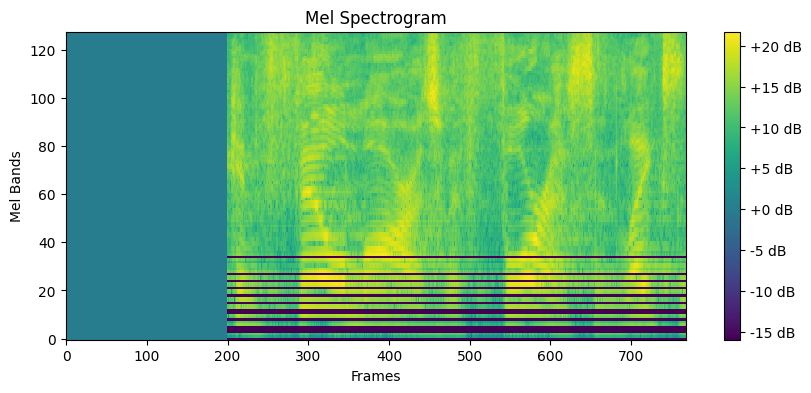

In [20]:
import matplotlib.pyplot as plt


video, audio = train_loader.dataset[N]
audio[:200,:] = 0
mel_spectrogram = audio.squeeze().T.detach().numpy()
#mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

maxmax = mel_spectrogram.max()
minmin = mel_spectrogram.min()

plt.figure(figsize=(10,4))
plt.imshow(mel_spectrogram, interpolation='nearest', vmax=maxmax, vmin=minmin, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.xlabel('Frames')
plt.ylabel('Mel Bands')
plt.show()

In [21]:
router.eval()


c = 0
for batch in train_loader:
    if c == N:
        video, audio = batch
        video, audio = video.to(device), audio.to(device)
        audio[:300,:] = 0
        out_v, out_a = router(video, audio, 0)
        break
    c += 1



In [22]:
print(out_v.shape, out_a.shape)

torch.Size([196, 768]) torch.Size([48, 768])


In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

def reduction(x):
    return torch.mean(x, dim=-1).unsqueeze(0)

def inter(x):
    return F.interpolate(x.unsqueeze(1), size=64, mode='linear', align_corners=False).squeeze(1)

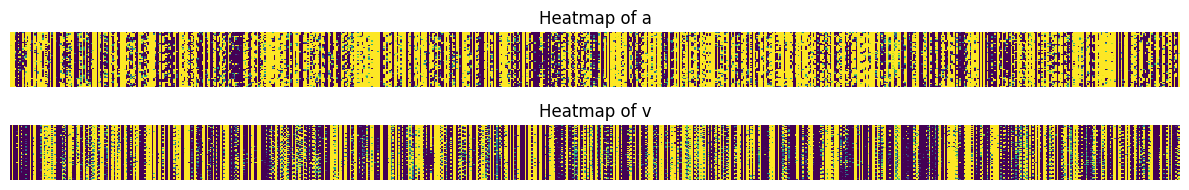

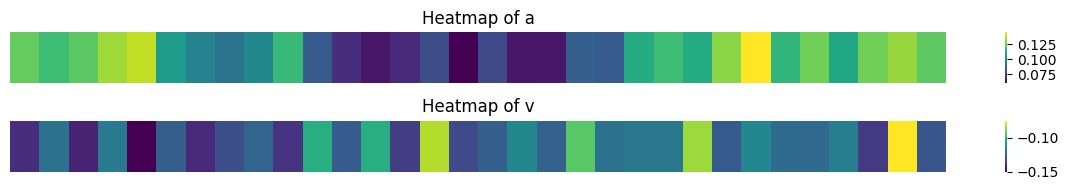

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

data_np = out_a.cpu().detach().numpy()
data_np2 = out_v.cpu().detach().numpy()


plt.figure(figsize=(12, 2))

plt.subplot(2, 1, 1) 
sns.heatmap(data_np, cmap='viridis', vmax=0.2, vmin=-0.5, cbar=False, xticklabels=False, yticklabels=False)
plt.title('Heatmap of a')

plt.subplot(2, 1, 2) 
sns.heatmap(data_np2, cmap='viridis', vmax=0.2, vmin=-0.5, cbar=False, xticklabels=False, yticklabels=False)
plt.title('Heatmap of v')

plt.tight_layout() 
plt.show()

v_r = inter(reduction(out_v))
a_r = inter(reduction(out_a))

data_np = a_r.cpu().detach().numpy()
data_np2 = v_r.cpu().detach().numpy()

plt.figure(figsize=(12, 2))

plt.subplot(2, 1, 1) 
sns.heatmap(data_np, cmap='viridis', cbar=True, xticklabels=False, yticklabels=False)
plt.title('Heatmap of a')

plt.subplot(2, 1, 2) 
sns.heatmap(data_np2, cmap='viridis', cbar=True, xticklabels=False, yticklabels=False)
plt.title('Heatmap of v')

plt.tight_layout() 
plt.show()


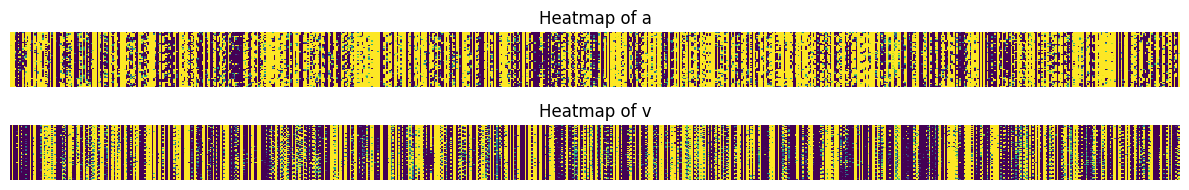

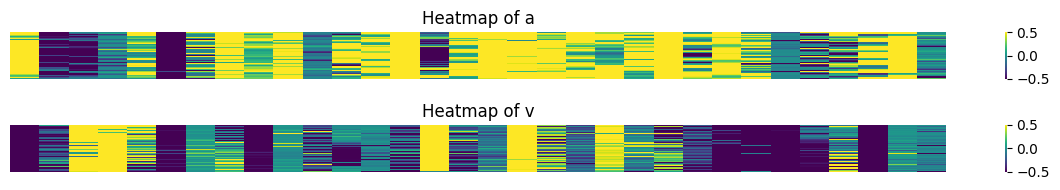

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

data_np = out_a.cpu().detach().numpy()
data_np2 = out_v.cpu().detach().numpy()


plt.figure(figsize=(12, 2))

plt.subplot(2, 1, 1) 
sns.heatmap(data_np, cmap='viridis', vmax=0.2, vmin=-0.5, cbar=False, xticklabels=False, yticklabels=False)
plt.title('Heatmap of a')

plt.subplot(2, 1, 2) 
sns.heatmap(data_np2, cmap='viridis', vmax=0.2, vmin=-0.5, cbar=False, xticklabels=False, yticklabels=False)
plt.title('Heatmap of v')

plt.tight_layout() 
plt.show()

v_r = inter(out_v)
a_r = inter(out_a)

data_np = a_r.cpu().detach().numpy()
data_np2 = v_r.cpu().detach().numpy()

plt.figure(figsize=(12, 2))

plt.subplot(2, 1, 1) 
sns.heatmap(data_np, cmap='viridis', vmax=0.5, vmin=-0.5, cbar=True, xticklabels=False, yticklabels=False)
plt.title('Heatmap of a')

plt.subplot(2, 1, 2) 
sns.heatmap(data_np2, cmap='viridis', vmax=0.5, vmin=-0.5, cbar=True, xticklabels=False, yticklabels=False)
plt.title('Heatmap of v')

plt.tight_layout() 
plt.show()


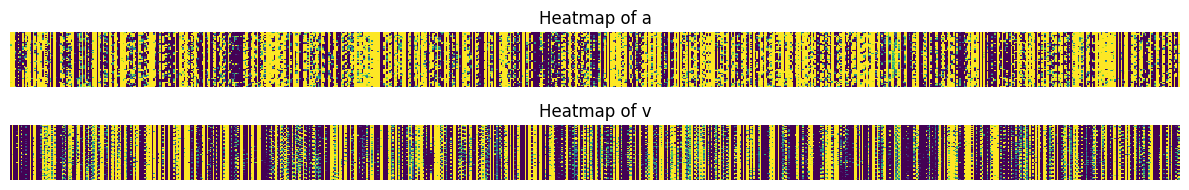

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

data_np = out_a.cpu().detach().numpy()
data_np2 = out_v.cpu().detach().numpy()


plt.figure(figsize=(12, 2))

plt.subplot(2, 1, 1) 
sns.heatmap(data_np, cmap='viridis', vmax=0.5, vmin=-0.5, cbar=False, xticklabels=False, yticklabels=False)
plt.title('Heatmap of a')

plt.subplot(2, 1, 2) 
sns.heatmap(data_np2, cmap='viridis', vmax=0.5, vmin=-0.5, cbar=False, xticklabels=False, yticklabels=False)
plt.title('Heatmap of v')

plt.tight_layout() 
plt.show()


### noise visualize

train::30782
train::30782
train::30782
train::30782
train::30782


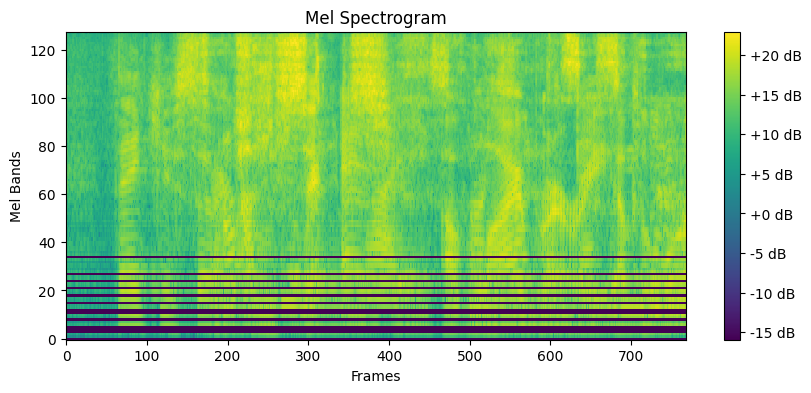

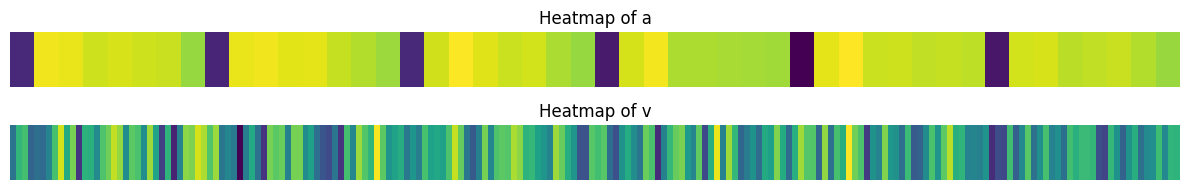

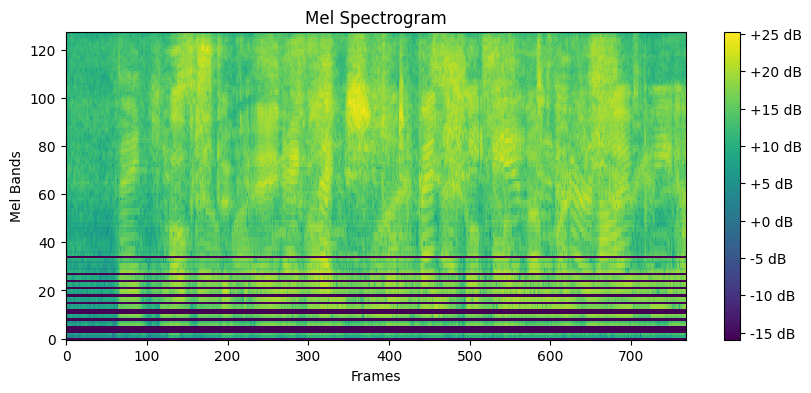

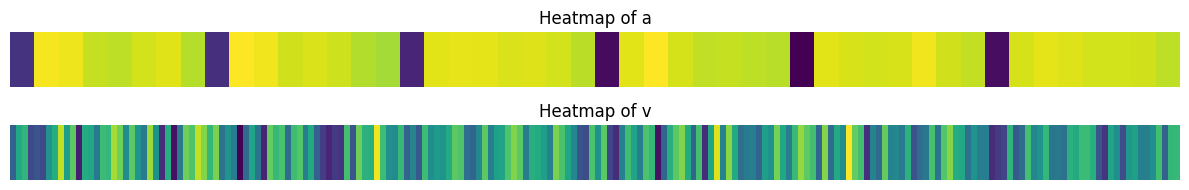

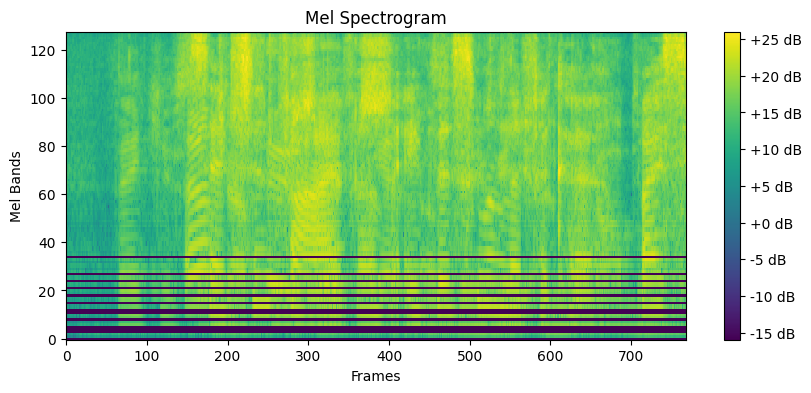

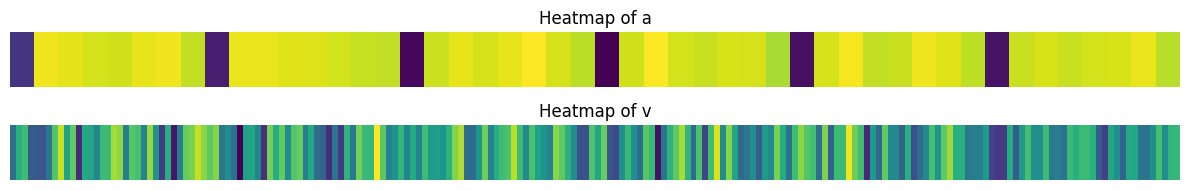

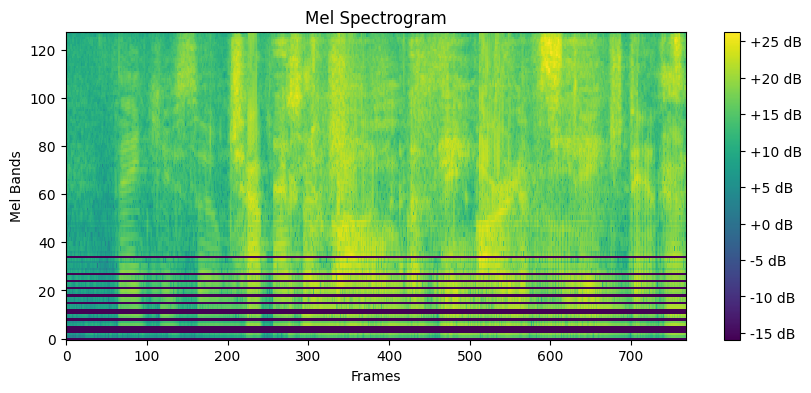

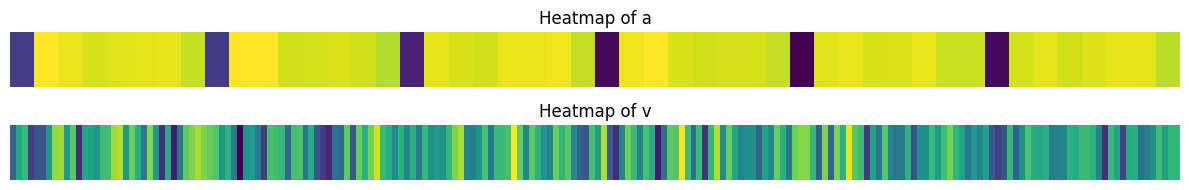

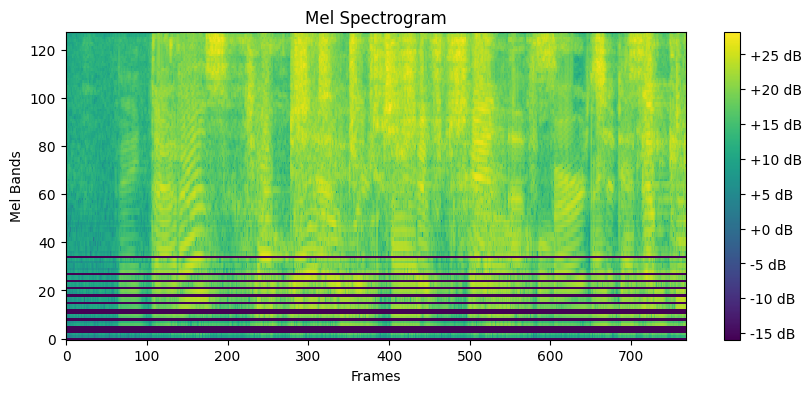

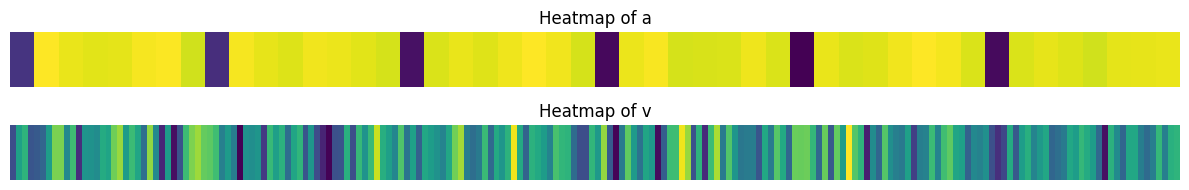

In [35]:
import torch
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

arr = [10, 5, 0, -5,-10]
# root_path = "/media/ldh/sda1/lrs3"
root_path = "/media/ldh/f57e2fef-dda3-4234-9232-3e2867058140/datasets/lip_reading/lrs3/30h_data"

noise_datasets = [LRS3Dataset(root_path, split="train", noise=True, snr=i) for i in arr]

num_workers = 2
noise_loaders = [DataLoader(noise_datasets[i], batch_size=1, shuffle=False, num_workers=num_workers, collate_fn=train_dataset.collate_fn) for i in range(len(arr))]


for i in range(len(arr)):
    video, audio = noise_loaders[i].dataset[76]
    # audio[:200,:]=0

    mel_spectrogram = audio.squeeze().T.detach().numpy()
    #mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    maxmax = mel_spectrogram.max()
    minmin = mel_spectrogram.min()

    plt.figure(figsize=(10,4))
    plt.imshow(mel_spectrogram, interpolation='nearest', vmax=maxmax, vmin=minmin, aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.xlabel('Frames')
    plt.ylabel('Mel Bands')
    plt.show()

    

    c = 0
    for batch in noise_loaders[i]:
        if c == N:
            video, audio = batch
            video, audio = video.to(device), audio.to(device)
            # audio[:200,:]=0
            out_v, out_a = router(video, audio, 0)
            break
        c += 1

    
    v_r = (reduction(out_v))
    a_r = (reduction(out_a))

    data_np = a_r.cpu().detach().numpy()
    data_np2 = v_r.cpu().detach().numpy()


    plt.figure(figsize=(12, 2))

    plt.subplot(2, 1, 1) 
    sns.heatmap(data_np, cmap='viridis',  cbar=False, xticklabels=False, yticklabels=False)
    plt.title('Heatmap of a')

    plt.subplot(2, 1, 2) 
    sns.heatmap(data_np2, cmap='viridis', cbar=False, xticklabels=False, yticklabels=False)
    plt.title('Heatmap of v')

    plt.tight_layout() 
    plt.show()


### visualize others

In [420]:
router.eval()


for batch in train_loader:
    video, audio = batch
    video, audio = video.to(device), audio.to(device)
    out_v, out_a = router(video, audio, 1)

    break



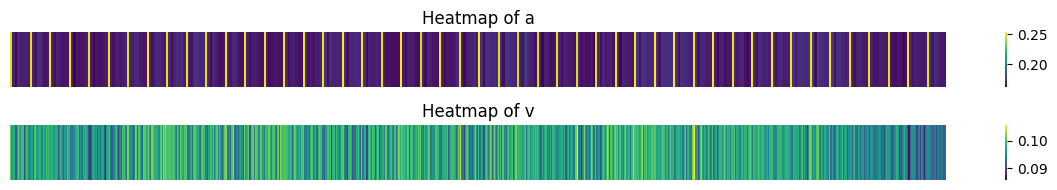

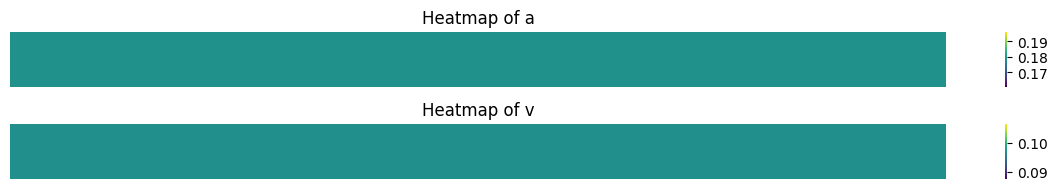

In [421]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

data_np = out_a.cpu().detach().numpy()
data_np2 = out_v.cpu().detach().numpy()

plt.figure(figsize=(12, 2))

plt.subplot(2, 1, 1) 
sns.heatmap(data_np, cmap='viridis', cbar=True, xticklabels=False, yticklabels=False)
plt.title('Heatmap of a')

plt.subplot(2, 1, 2) 
sns.heatmap(data_np2, cmap='viridis', cbar=True, xticklabels=False, yticklabels=False)
plt.title('Heatmap of v')

plt.tight_layout() 
plt.show()


v_r = inter(reduction(out_v))
a_r = inter(reduction(out_a))

data_np = a_r.cpu().detach().numpy()
data_np2 = v_r.cpu().detach().numpy()

plt.figure(figsize=(12, 2))

plt.subplot(2, 1, 1) 
sns.heatmap(data_np, cmap='viridis', cbar=True, xticklabels=False, yticklabels=False)
plt.title('Heatmap of a')

plt.subplot(2, 1, 2) 
sns.heatmap(data_np2, cmap='viridis', cbar=True, xticklabels=False, yticklabels=False)
plt.title('Heatmap of v')

plt.tight_layout() 
plt.show()


In [422]:
router.eval()


for batch in train_loader:
    video, audio = batch
    video, audio = video.to(device), audio.to(device)
    out_v, out_a = router(video, audio, 2)

    break



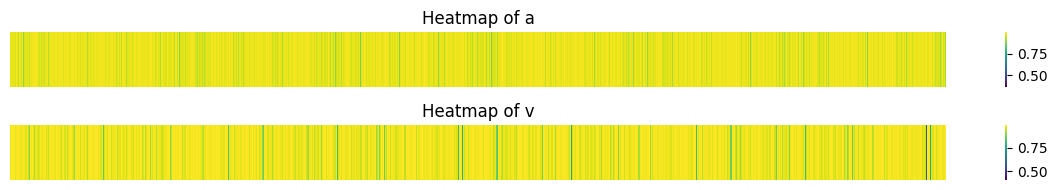

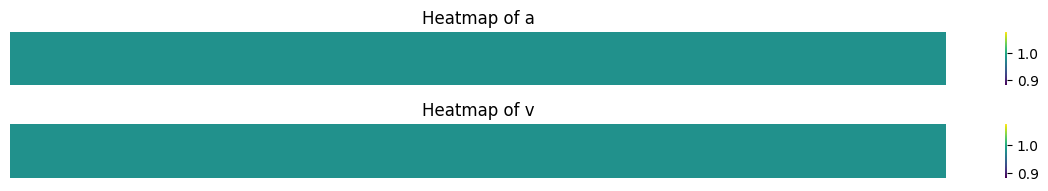

In [423]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F


data_np = out_a.cpu().detach().numpy()
data_np2 = out_v.cpu().detach().numpy()

plt.figure(figsize=(12, 2))

plt.subplot(2, 1, 1) 
sns.heatmap(data_np, cmap='viridis', cbar=True, xticklabels=False, yticklabels=False)
plt.title('Heatmap of a')

plt.subplot(2, 1, 2) 
sns.heatmap(data_np2, cmap='viridis', cbar=True, xticklabels=False, yticklabels=False)
plt.title('Heatmap of v')

plt.tight_layout() 
plt.show()

v_r = inter(reduction(out_v))
a_r = inter(reduction(out_a))

data_np = a_r.cpu().detach().numpy()
data_np2 = v_r.cpu().detach().numpy()

plt.figure(figsize=(12, 2))

plt.subplot(2, 1, 1) 
sns.heatmap(data_np, cmap='viridis', cbar=True, xticklabels=False, yticklabels=False)
plt.title('Heatmap of a')

plt.subplot(2, 1, 2) 
sns.heatmap(data_np2, cmap='viridis', cbar=True, xticklabels=False, yticklabels=False)
plt.title('Heatmap of v')

plt.tight_layout() 
plt.show()


# test

In [88]:
import torch.nn as nn
import torch.nn.functional as F


class classifier(nn.Module):
    def __init__(self, model_name, target_dim=64, num_class=1):
        super(classifier, self).__init__()

        self.model_trained = AVFF()
        self.model_trained.load_state_dict(torch.load(f'{model_name}.pth'))
        self.target_dim = target_dim

        self.fc = nn.Linear(target_dim*2, num_class)
        
        self.init()

    def init(self):        
        for param in self.model_trained.parameters():
            param.requires_grad = False

        for param in self.fc.parameters():
            param.requires_grad = True
        
        self.model_trained.eval()

    def forward(self, v, a, mode=0):
        B, F_v, C, H, W = v.shape
        _, F_a, M = a.shape
        v_s, a_s = self.get_slices(v, a)
        
        n_s = v_s.size(1) // B

        out_v = []
        out_a = []

        for i in range(B):
            if mode==0:
                x_v, x_a = self.forward_slice_cossim(v_s[i], a_s[i])
            elif mode == 1:
                x_v, x_a = self.forward_slice_L2(v_s[i], a_s[i])
            elif mode == 2:
                x_v, x_a = self.forward_slice_std(v_s[i], a_s[i])
                
            x_v = x_v.view(-1, x_v.size(1))
            x_a = x_a.view(-1, x_a.size(1))
            out_v.append(x_v)
            out_a.append(x_a)

        out_v = torch.stack(out_v).view(B, -1)
        out_a = torch.stack(out_a).view(B, -1)

        out_v, out_a = self.min_max_norm(out_v), self.min_max_norm(out_a) 
        x = torch.cat((out_v, out_a), dim=1)
        x = self.fc(x)
        return x

    def forward_slice_cossim(self, v, a):
        B = v.size(0)
        v = v.permute(0, 2, 1, 3, 4)
        #v = self.model_trained._crop_face(v).to(self.model_trained.device)
        x_v, x_a = self.model_trained.encoding(v, a)

        v_a = self.model_trained.A2V(x_a)
        a_v = self.model_trained.V2A(x_v)

        d_v = F.cosine_similarity(x_v, v_a, dim=1)
        d_a = F.cosine_similarity(x_a, a_v, dim=1)

        d_v = self.reduction(d_v).view(B, -1)
        d_a = self.reduction(d_a).view(B, -1)
        
        d_v = self.interpolation(d_v)
        d_a = self.interpolation(d_a)

        return d_v, d_a
    
    def forward_slice_L2(self, v, a):
        B = v.size(0)
        v = v.permute(0, 2, 1, 3, 4)
        #v = self.model_trained._crop_face(v).to(self.model_trained.device)
        x_v, x_a = self.model_trained.encoding(v, a)

        v_a = self.model_trained.A2V(x_a)
        a_v = self.model_trained.V2A(x_v)

        d_v = 1 - torch.sqrt(torch.mean((x_v - v_a)**2, dim=-1)).view(B, -1)
        d_a = 1 - torch.sqrt(torch.mean((x_a - a_v)**2, dim=-1)).view(B, -1)

        #d_v = self.reduction(d_v).view(B, -1)
        #d_a = self.reduction(d_a).view(B, -1)
        
        d_v = self.interpolation(d_v)
        d_a = self.interpolation(d_a)

        return d_v, d_a
    
    def forward_slice_std(self, v, a):
        B = v.size(0)
        v = v.permute(0, 2, 1, 3, 4)
        x_v, x_a = self.model_trained.encoding(v, a)

        v_a = self.model_trained.A2V(x_a)
        a_v = self.model_trained.V2A(x_v)
        
        d_v = 1-torch.std((x_v + v_a)/2, dim=-1).view(B, -1)
        d_a = 1-torch.std((x_a + a_v)/2, dim=-1).view(B, -1)

        d_v = self.interpolation(d_v)
        d_a = self.interpolation(d_a)

        return d_v, d_a
        
    def get_slices(self, video, audio):
        B, F, C, H, W = video.shape
        fps = 5
        n_v = video.size(1)
        n_a = audio.size(1)

        video_slice_length = int(3.2 * fps)
        audio_slice_length = int(768)

        video_slices = []
        audio_slices = []

        for b in range(B):
            for start in range(0, n_v, int(3.2 * fps)):
                if start + video_slice_length <= n_v:
                    video_slices.append(video[b, start:start + video_slice_length])
                else:
                    pad_size = (start + video_slice_length) - n_v
                    padded_slice = torch.cat((video[b, start:], torch.zeros((pad_size, C, H, W), device=video.device)))
                    video_slices.append(padded_slice)

        v_s = torch.stack(video_slices).view(B, -1, video_slice_length, C, H, W)

        for b in range(B):
            for start in range(0, n_a, int(768)):
                if start + audio_slice_length <= n_a:
                    audio_slices.append(audio[b, start:start + audio_slice_length])
                else:
                    pad_size = (start + audio_slice_length) - n_a
                    padded_slice = torch.cat((audio[b, start:], torch.zeros((pad_size, 128), device=audio.device)))
                    audio_slices.append(padded_slice)

        a_s = torch.stack(audio_slices).view(B, -1, audio_slice_length, 128)

        return v_s, a_s

    def min_max_norm(self, tensor):
        min_val = tensor.min(dim=1, keepdim=True)[0]
        max_val = tensor.max(dim=1, keepdim=True)[0]
        normalized_tensor = (tensor - min_val) / (max_val - min_val + 0.001)
        return normalized_tensor

    def reduction(self, x):
        x = torch.mean(x, dim=-1)

        return x
    
    def interpolation(self, x):
        x = F.interpolate(x.unsqueeze(1), size=self.target_dim , mode='linear', align_corners=False).squeeze(1)

        return x
    
    def mel_preprocessing_new(self, audio_data, sr=16000):
        fbank = kaldi.fbank(audio_data, htk_compat=True, sample_frequency=sr, use_energy=False, 
        window_type='hanning', num_mel_bins=128, dither=0.0,frame_shift=4 ,frame_length= 16)
        n_frames = fbank.shape[0]
        TARGET_LEN = 768
        p = TARGET_LEN - n_frames
        # cut and pad
        if p > 0:
            m = torch.nn.ZeroPad2d((0, 0, 0, p))
            fbank = m(fbank)
        elif p < 0:
            fbank = fbank[0:TARGET_LEN, :]
        return fbank


    def norm_fbank(self, fbank):
        norm_mean= -4.2677393
        norm_std= 4.5689974
        fbank = (fbank - norm_mean) / (norm_std * 2)
        return fbank
    
    def data_preprocessing(self, data, type):
        if type == 'audio':
            audio = self.mel_preprocessing_new(data)
            return audio
        
        if type == "video":
            video = data
            step = float(25) / 5
            if step.is_integer():
                step = int(step)
                idxs = slice(None, None, step)
            else:
                num_frames = max(int(len(video) / step), 1)
                idxs = torch.arange(num_frames, dtype=torch.float32) * step
                idxs = idxs.floor().to(torch.int64)
            video = video[idxs]
            
            return video

In [52]:
import torch
from dataset.FakeAVCeleb import FakeAVCeleb
from dataset.LAV_DF import *
from torch.utils.data import DataLoader
from paths import LAVDF_PATH, FAKEAVCELEB_PATH

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

root_dir = FAKEAVCELEB_PATH

train_dataset = FakeAVCeleb(root_dir=root_dir, split='train', num_samples=5000)
val_dataset = FakeAVCeleb(root_dir=root_dir, split='val', num_samples=5000)
test_dataset = FakeAVCeleb(root_dir=root_dir, split='test', num_samples=5000)

num_workers = 0
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=num_workers, collate_fn=train_dataset.collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=num_workers, collate_fn=val_dataset.collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=num_workers, collate_fn=test_dataset.collate_fn)

for video, audio, label, meta in train_loader:
    print(f"Train Video shape: {video.shape}, {audio.shape}, Label: {label}")

    break

Balanced samples: 686 (Real: 343, Fake: 343)
train::686
val::3234
test::3236
Train Video shape: torch.Size([1, 16, 3, 224, 224]), torch.Size([1, 768, 128]), Label: tensor([1])


In [53]:
model_name = "trained/lrs3_5epoch"

detector = classifier(model_name).to("cuda")

/home/ldh/avsr/AVFF/model/marlin_pytorch/model/marlin.py:202: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  state_dict = torch.load(path, map_location="cpu")
/home/ldh/avsr/AVFF/model/AVFF.py:96: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  checkpoint = torch.load(audioMAE_path, map_location='cuda')
/tmp/ipykernel_5115/1167336896.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  self.model_trained.load_state_dict(torch.load(f'{model_name}.pth'))


In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

NUM_EPOCH = 20
LR = 0.004

optimizer = optim.AdamW(detector.parameters(), lr=LR)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(NUM_EPOCH):
    detector.train()  
    total_loss = 0 
    count = 0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{NUM_EPOCH}', leave=False):
        v, a, l, meta = batch
        if v==None:
            continue
        batch_index = v.shape[0]

        for index in range(batch_index):
            video, audio, label = v[index:index+1].to(device), a[index:index+1].to(device), l[index:index+1].to(device)
            #video = video.permute(0, 2, 1, 3, 4)
            label = label.view(-1, 1).float()
        
            optimizer.zero_grad()

            pred = detector(video, audio)
            #pred = detector.forward_slice(video, audio)
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            count += 1

    avg_loss = total_loss / count
    
    print(f'Epoch [{epoch + 1}/{NUM_EPOCH}], Average Loss: {avg_loss:.4f}')


    
    torch.save(detector.state_dict(), f'trained/detector_full_double_30epoch_2.pth')


Epoch [1/20], Average Loss: 0.5488


Epoch [2/20], Average Loss: 0.5198


Epoch [3/20], Average Loss: 0.4880


Epoch [4/20], Average Loss: 0.4805


Epoch [5/20], Average Loss: 0.4538


Epoch [6/20], Average Loss: 0.4468


Epoch [7/20], Average Loss: 0.4375


Epoch [8/20], Average Loss: 0.4339


Epoch [9/20], Average Loss: 0.4180


Epoch [10/20], Average Loss: 0.4113


Epoch [11/20], Average Loss: 0.4033


Epoch [12/20], Average Loss: 0.4004


Epoch [13/20], Average Loss: 0.4014


Epoch [14/20], Average Loss: 0.4000


Epoch [15/20], Average Loss: 0.3961


Epoch [16/20], Average Loss: 0.3930


Epoch [17/20], Average Loss: 0.3903


Epoch [18/20], Average Loss: 0.3918


Epoch [19/20], Average Loss: 0.3948


Epoch [20/20], Average Loss: 0.3798


In [59]:
detector.eval()

pred_labels = []
labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Validation', leave=False):
        video, audio, label, meta = batch
        if video==None:
            continue
        video, audio, label = video.to(device), audio.to(device), label.to(device)

        pred = detector(video, audio)
        pred_probs = torch.sigmoid(pred)
        
        pred_labels.extend(pred_probs.cpu().numpy())
        labels.extend(label.cpu().numpy())

EER, accuracy, f1, min_dcf = calculate_metrics(labels, pred_labels)
print(EER, accuracy, f1, min_dcf)


FPR: [0.00000000e+00 3.32115576e-04 2.32480903e-03 2.32480903e-03
 3.98538691e-03 3.98538691e-03 8.30288941e-03 8.30288941e-03
 1.09598140e-02 1.09598140e-02 1.22882763e-02 1.22882763e-02
 1.36167386e-02 1.36167386e-02 1.46130854e-02 1.46130854e-02
 1.59415477e-02 1.59415477e-02 2.25838592e-02 2.25838592e-02
 2.82298240e-02 2.82298240e-02 2.92261707e-02 2.92261707e-02
 4.31750249e-02 4.31750249e-02 4.35071405e-02 4.35071405e-02
 4.51677184e-02 4.51677184e-02 4.91531053e-02 4.91531053e-02
 5.21421455e-02 5.21421455e-02 5.67917635e-02 5.67917635e-02
 5.81202258e-02 5.81202258e-02 6.27698439e-02 6.27698439e-02
 6.31019595e-02 6.31019595e-02 6.34340751e-02 6.34340751e-02
 6.54267685e-02 6.54267685e-02 6.74194620e-02 6.74194620e-02
 6.87479243e-02 6.87479243e-02 7.33975423e-02 7.33975423e-02
 7.40617735e-02 7.40617735e-02 9.43208236e-02 9.43208236e-02
 9.49850548e-02 9.49850548e-02 9.83062106e-02 9.83062106e-02
 1.08601793e-01 1.08601793e-01 1.10926602e-01 1.10926602e-01
 1.14911989e-01 1.1

# classifier

In [60]:
import torch
import torch.nn as nn
from model.AVFF import AVFF
from model.marlin_pytorch.model.modules import MLP

In [68]:

class classifier(nn.Module):
    def __init__(self, model_name):
        super(classifier, self).__init__()

        self.model_trained = AVFF()
        self.model_trained.load_state_dict(torch.load(f'{model_name}.pth'))
        self.v_reduction = MLP([768*2, 768, 256, 64], build_activation=nn.LeakyReLU)
        self.a_reduction = MLP([768*2, 768, 256, 64], build_activation=nn.LeakyReLU)

        self.fc = MLP([244 * 64, 122 * 64, 128, 64, 1], build_activation=nn.LeakyReLU)
        self.init()

    def init(self):
        #self.model_trained = self.model_trained.half()
        
        for param in self.model_trained.parameters():
            param.requires_grad = False
        
        self.model_trained.eval()

    def forward(self, v, a):
        v_s, a_s = self.get_slices(v, a)
        B = v_s.size(0)
        x = self.forward_slice(v_s, a_s)
        x = torch.mean(x, dim=-1)
        x = x.unsqueeze(0)
        return x

    def forward_slice(self, v, a):
        B = v.size(0)
        v = v.permute(0, 2, 1, 3, 4)
        #v = self.model_trained._crop_face(v).to(self.model_trained.device)
        x_v, x_a = self.model_trained.encoding(v, a)

        a_v = self.model_trained.A2V(x_a)
        v_a = self.model_trained.V2A(x_v)

        f_v = torch.cat((x_v, a_v), dim=-1)
        f_a = torch.cat((x_a, v_a), dim=-1)

        f_v, f_a = self.reduction(f_v, f_a)
        f_concat = torch.cat((f_v, f_a), dim=2)
        # B, 8, 244(48+196), 64
        f_concat = f_concat.view(B, 8, -1)

        x = self.fc(f_concat)
        # B, 8, 1
        x = x.mean(dim=1).squeeze(1)

        return x
    
    def get_slices(self, video, audio):
        B, F, C, H, W = video.shape
        video = video.view(1, B*F, C, H, W)
        audio = audio.view(1, B*768, 128)

        n_v = video.size(1)
        n_a = audio.size(1)

        video_slices = []

        for start in range(0, 16, 2):
            if start + 16 <= n_v:
                video_slices.append(video[0, start:start + 16])
            else:
                pad_size = (start + 16) - 16
                padded_slice = torch.cat((video[0, start:], torch.zeros((pad_size, 3, 224, 224), device=video.device)))
                video_slices.append(padded_slice)

        v_s = torch.stack(video_slices)  # (N, 16, 3, 224, 224)

        audio_slices = []
        for start in range(0, 768, 768 // 8): 
            if start + 768 <= n_a:
                audio_slices.append(audio[0, start:start + 768])
            else:
                pad_size = (start + 768) - n_a
                padded_slice = torch.cat((audio[0, start:], torch.zeros((pad_size, 128), device=audio.device)))
                audio_slices.append(padded_slice)

        a_s = torch.stack(audio_slices)  # (N, 768/8, 128)

        return v_s, a_s

    def reduction(self, f_v, f_a):
        B, S, N, F = f_v.shape
        f_v = self.v_reduction(f_v)
        f_a = self.a_reduction(f_a)

        f_v = f_v.view(B, S, -1, 64)
        f_a = f_a.view(B, S, -1, 64)
        return f_v, f_a

In [69]:
model_name = "trained/lrs3_5epoch"

detector = classifier(model_name).to("cuda")

/tmp/ipykernel_5115/4189106341.py:6: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  self.model_trained.load_state_dict(torch.load(f'{model_name}.pth'))


In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

NUM_EPOCH = 20
LR = 0.0004

optimizer = optim.AdamW(detector.parameters(), lr=LR)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(NUM_EPOCH):
    detector.train()  
    total_loss = 0 
    count = 0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{NUM_EPOCH}', leave=False):
        v, a, l, meta = batch
        if v==None:
            continue
        batch_index = v.shape[0]

        for index in range(batch_index):
            video, audio, label = v[index:index+1].to(device), a[index:index+1].to(device), l[index:index+1].to(device)
            #video = video.permute(0, 2, 1, 3, 4)
            #label = label.view(-1, 1).float()
        
            optimizer.zero_grad()

            pred = detector(video, audio)
            #pred = detector.forward_slice(video, audio)
            loss = criterion(pred, label.float())
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            count += 1

    avg_loss = total_loss / count
    
    print(f'Epoch [{epoch + 1}/{NUM_EPOCH}], Average Loss: {avg_loss:.4f}')


    
    torch.save(detector.state_dict(), f'trained/detector_20epoch.pth')

Epoch [1/20], Average Loss: 0.5586


Epoch [2/20], Average Loss: 0.3195


Epoch [3/20], Average Loss: 0.3228


Epoch [4/20], Average Loss: 0.3214


Epoch [5/20], Average Loss: 1.0130


Epoch [6/20], Average Loss: 0.3229


Epoch [7/20], Average Loss: 0.3211


Epoch [8/20], Average Loss: 0.3135


Epoch [9/20], Average Loss: 0.3997


Epoch [10/20], Average Loss: 0.3320


Epoch [11/20], Average Loss: 0.3041


Epoch [12/20], Average Loss: 1.3678


Epoch [13/20], Average Loss: 0.3209


Epoch [14/20], Average Loss: 0.3018


Epoch [15/20], Average Loss: 0.3108


Epoch [16/20], Average Loss: 0.3009


Epoch [17/20], Average Loss: 0.3095


Epoch [18/20], Average Loss: 0.3171


Epoch [19/20], Average Loss: 0.5483


Epoch [20/20], Average Loss: 0.3528


# Metric

In [47]:
import numpy as np
from tqdm import tqdm
from sklearn.metrics import roc_curve, accuracy_score, f1_score

def calculate_metrics(labels, scores, threshold=0.5):
    labels = np.array(labels)
    scores = np.array(scores)
    fpr, tpr, thresholds = roc_curve(labels, scores, pos_label=1)
    fnr = 1 - tpr

    print("FPR:", fpr)
    print("FNR:", fnr)

    min_index = np.argmin(np.abs(fpr - fnr))
    EER = (fpr[min_index] + fnr[min_index]) / 2
    eer_threshold = thresholds[min_index]

    predictions = [1 if score >= threshold else 0 for score in scores]

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)

    min_dcf = calculate_min_dcf(labels, scores)

    return EER, accuracy, f1, min_dcf

In [48]:
def calculate_min_dcf(labels, scores, p_target=0.5, c_miss=2, c_fa=1):
    fpr, tpr, thresholds = roc_curve(labels, scores, pos_label=1)
    fnr = 1 - tpr

    dcf = p_target * c_miss * fnr + (1 - p_target) * c_fa * fpr
    min_dcf = np.min(dcf)

    print("FPR:", fpr)
    print("TPR:", tpr)
    print("FNR:", fnr)
    print("DCF:", dcf)

    return min_dcf


# eval

In [ ]:
detector.eval()

pred_labels = []
labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Validation', leave=False):
        video, audio, label, meta = batch
        if video==None:
            continue
        video, audio, label = video.to(device), audio.to(device), label.to(device)

        pred = detector(video, audio)
        pred_probs = torch.sigmoid(pred)
        
        pred_labels.extend(pred_probs.cpu().numpy())
        labels.extend(label.cpu().numpy())

EER, accuracy, f1, min_dcf = calculate_metrics(labels, pred_labels)
print(EER, accuracy, f1, min_dcf)


# attention visualize

In [1]:
folder = "/home/ldh/AVSR/outputs"

In [2]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

import os

tensors = dict()
for n in ["av_tensor", "v_tensor", "a_tensor", "ca_tensor", "score_ca_tensor"]:
    load_path = os.path.join(folder, n+".pt")
    tensors[n] = torch.load(load_path, map_location='cpu', weights_only=False)


In [3]:
print(tensors)

{'av_tensor': tensor([[[-0.3657, -0.0858, -0.2804,  ..., -0.0454, -0.0587, -0.1824],
         [-0.1626, -0.0587, -0.1864,  ..., -0.1227,  0.1995, -0.3723],
         [ 0.0096, -0.0610, -0.1166,  ..., -0.1763,  0.2943, -0.3980],
         ...,
         [-0.2229,  0.0051, -0.1770,  ..., -0.3808,  0.2698, -0.2496],
         [-0.2125,  0.1346, -0.1944,  ..., -0.1929,  0.0309, -0.0597],
         [ 0.0905, -0.0492,  0.2004,  ..., -0.1171,  0.1890, -0.1526]],

        [[-0.4174, -0.0378, -0.3002,  ..., -0.0707, -0.0421, -0.2529],
         [-0.2231, -0.0124, -0.2048,  ..., -0.1719,  0.1729, -0.3794],
         [-0.0666,  0.1188, -0.1092,  ..., -0.2520,  0.1056, -0.4609],
         ...,
         [ 0.0371,  0.4307,  0.1428,  ..., -0.5652, -0.0239, -0.0022],
         [ 0.1434,  0.2197,  0.2269,  ..., -0.6986,  0.1577,  0.0658],
         [ 0.2829,  0.0266,  0.2187,  ..., -0.4412,  0.4145, -0.1607]]]), 'v_tensor': tensor([[[-0.4768, -0.0433, -0.2842,  ...,  0.0054,  0.0447, -0.2327],
         [-0.0914,

In [4]:
for k in tensors.keys():
    print(tensors[k].shape)

torch.Size([2, 155, 768])
torch.Size([2, 155, 768])
torch.Size([2, 155, 768])
torch.Size([10, 1, 768])
torch.Size([10, 1, 768])


NumPy 배열 모양: (2, 155, 768)

seaborn으로 히트맵 시각화 중...


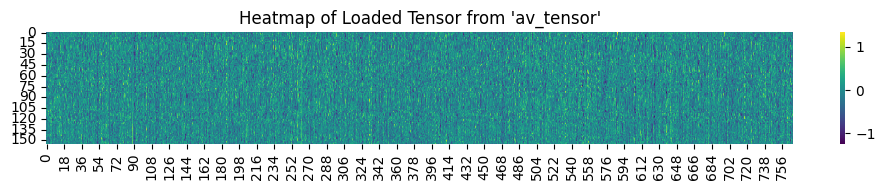

In [12]:
loaded_numpy_array = (tensors['av_tensor']).numpy()

print(f"NumPy 배열 모양: {loaded_numpy_array.shape}")

print("\nseaborn으로 히트맵 시각화 중...")

plt.figure(figsize=(10, 2))

sns.heatmap(loaded_numpy_array[0], 
            cmap='viridis', # 또는 'plasma', 'coolwarm', 'Blues' 등
            # vmin=loaded_numpy_array.min(), vmax=loaded_numpy_array.max() # 실제 값 범위로 설정
            # annot=False, # 값을 표시하려면 True
            # fmt='.2f',   # 값 표시 형식
            )

plt.title(f"Heatmap of Loaded Tensor from 'av_tensor'")



plt.tight_layout() 
plt.show()

NumPy 배열 모양: (2, 155, 768)

seaborn으로 히트맵 시각화 중...


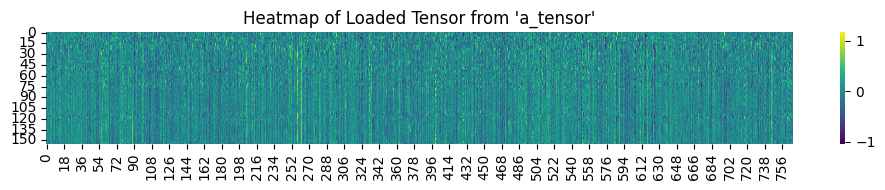

In [13]:
loaded_numpy_array = (tensors['a_tensor']).numpy()

print(f"NumPy 배열 모양: {loaded_numpy_array.shape}")

print("\nseaborn으로 히트맵 시각화 중...")

plt.figure(figsize=(10, 2))

sns.heatmap(loaded_numpy_array[0], 
            cmap='viridis', # 또는 'plasma', 'coolwarm', 'Blues' 등
            # vmin=loaded_numpy_array.min(), vmax=loaded_numpy_array.max() # 실제 값 범위로 설정
            # annot=False, # 값을 표시하려면 True
            # fmt='.2f',   # 값 표시 형식
            )

plt.title(f"Heatmap of Loaded Tensor from 'a_tensor'")



plt.tight_layout() 
plt.show()

NumPy 배열 모양: (2, 155, 768)

seaborn으로 히트맵 시각화 중...


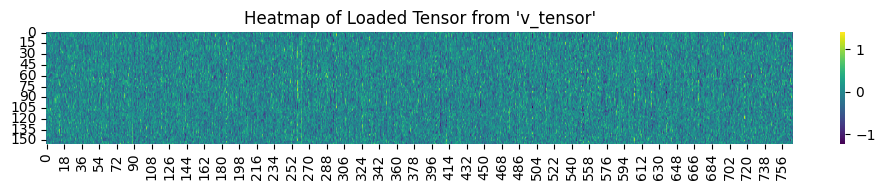

In [14]:
loaded_numpy_array = (tensors['v_tensor']).numpy()

print(f"NumPy 배열 모양: {loaded_numpy_array.shape}")

print("\nseaborn으로 히트맵 시각화 중...")

plt.figure(figsize=(10, 2))

sns.heatmap(loaded_numpy_array[0], 
            cmap='viridis', # 또는 'plasma', 'coolwarm', 'Blues' 등
            # vmin=loaded_numpy_array.min(), vmax=loaded_numpy_array.max() # 실제 값 범위로 설정
            # annot=False, # 값을 표시하려면 True
            # fmt='.2f',   # 값 표시 형식
            )

plt.title(f"Heatmap of Loaded Tensor from 'v_tensor'")



plt.tight_layout() 
plt.show()

In [21]:
torch.all(torch.ne(tensors['av_tensor'][0], tensors['v_tensor'][0])==False)

tensor(False)